### DNN inference, model which was build on Panasonic dataset are testing on LG dataset

In [121]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict
import os

In [56]:
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Voltage Average', 'Current Average', 'Power [W]', 'Cumulative_Capacity_Ah']
LABEL_COL = 'SOC [-]'

In [57]:
# DNN Model
class SoCDNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.1):
        super(SoCDNN, self).__init__()

        self.hidden_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()

        # First layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_size))
        self.batch_norm_layers.append(nn.BatchNorm1d(hidden_size))

        # Dynamically add hidden layers
        for i in range(1, num_layers):
            layer_size = hidden_size // (2 ** i)
            self.hidden_layers.append(nn.Linear(hidden_size // (2 ** (i - 1)), layer_size))
            self.batch_norm_layers.append(nn.BatchNorm1d(layer_size))

        # Output layer
        self.output_layer = nn.Linear(hidden_size // (2 ** (num_layers - 1)), 1)

        # Activation and Dropout against Regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for hidden_layer, batch_norm_layer in zip(self.hidden_layers, self.batch_norm_layers):
            x = self.relu(batch_norm_layer(hidden_layer(x)))
            x = self.dropout(x)

        x = self.output_layer(x)
        return x


In [58]:
def load_model(model_path, input_size, hidden_size, num_layers, dropout):
    model = SoCDNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    model.load_state_dict(torch.load(model_path)['model_state_dict'])
    model.eval()
    return model

In [59]:
hidden_size = 1024
num_layers = 5
input_size = len(FEATURE_COLS)
dropout = 0.3465

In [60]:
model_path = "../training_and_testing/for_panasonic_data/soc_dnn_model.pth"
model = load_model(model_path, input_size, hidden_size, num_layers, dropout)

In [125]:
def collect_data(cycle_name):
    results = defaultdict(dict)

    base_path = '../datasets/LG_dataset/LG_HG2_processed'


    temp_folders = ['0degC', '10degC', '25degC', '40degC', 'n10degC', 'n20degC']


    for temp_folder in temp_folders:
        folder_path = os.path.join(base_path, temp_folder)

        for file in os.listdir(folder_path):
            if cycle_name in file and file.endswith('.csv'):
                file_path = os.path.join(folder_path, file)
                

                test_df = pd.read_csv(file_path)
                test_df['Power [W]'] = test_df['Voltage [V]'] * test_df['Current [A]']
                
                rolling_window = 500
                test_df['Voltage Average'] = test_df['Voltage [V]'].rolling(rolling_window).mean()
                test_df['Current Average'] = test_df['Current [A]'].rolling(rolling_window).mean()
                test_df['SourceFile'] = file
                

                scaler = StandardScaler()
                test_df[FEATURE_COLS] = scaler.fit_transform(test_df[FEATURE_COLS])
                

                test_tensor = torch.tensor(test_df[FEATURE_COLS].values, dtype=torch.float32)
                test_labels = torch.tensor(test_df[LABEL_COL].values, dtype=torch.float32)
                

                results[temp_folder][file] = {
                    'dataframe': test_df,
                    'tensor': test_tensor,
                    'labels': test_labels,
                    'scaler': scaler
                }
    return results

In [123]:
def evaluate_and_plot(model, results):
    # Создадим структуру для хранения метрик
    metrics = {}
    
    # Проходим по всем температурным папкам и файлам
    for temp_folder, files_data in results.items():
        metrics[temp_folder] = {}
        
        for file_name, file_data in files_data.items():
            test_df = file_data['dataframe']
            test_tensor = file_data['tensor']
            test_labels = file_data['labels']
            
            # Получаем предсказания
            with torch.no_grad():
                predictions = model(test_tensor)
                predictions = predictions.cpu().view(-1).numpy()
                labels = test_labels.cpu().view(-1).numpy()
            
            # Подготовка данных
            times = test_df['Time [s]'].values
            prediction_np = np.array(predictions)
            test_label_np = np.array(labels)
            
            # Удаляем NaN значения
            mask = ~np.isnan(test_label_np) & ~np.isnan(prediction_np)
            test_label_clean = test_label_np[mask]
            prediction_clean = prediction_np[mask]
            times_clean = times[mask]
            
            # Вычисляем метрики
            mse = mean_squared_error(test_label_clean, prediction_clean)
            mae = mean_absolute_error(test_label_clean, prediction_clean)
            stddev = np.std(test_label_clean - prediction_clean)
            
            # Сохраняем метрики
            metrics[temp_folder][file_name] = {
                'MSE': mse,
                'MAE': mae,
                'StdDev': stddev
            }
            
            # Строим график
            plt.figure(figsize=(12, 6))
            plt.plot(times_clean, test_label_clean, label='True SOC', color='blue')
            plt.plot(times_clean, prediction_clean, label='Predicted SOC', color='red')
            plt.title(f'Temperature and cycle: {temp_folder} and {file_name}')
            plt.xlabel('Time [s]')
            plt.ylabel('SOC')
            plt.legend()
            plt.show()
            
            # Выводим метрики
            print(f"\nMetrics for {temp_folder}/{file_name}:")
            print(f"Test MSE: {mse:.6f}")
            print(f"Test MAE: {mae:.6f}")
            print(f"Test StdDev: {stddev:.6f}")
    
    return metrics

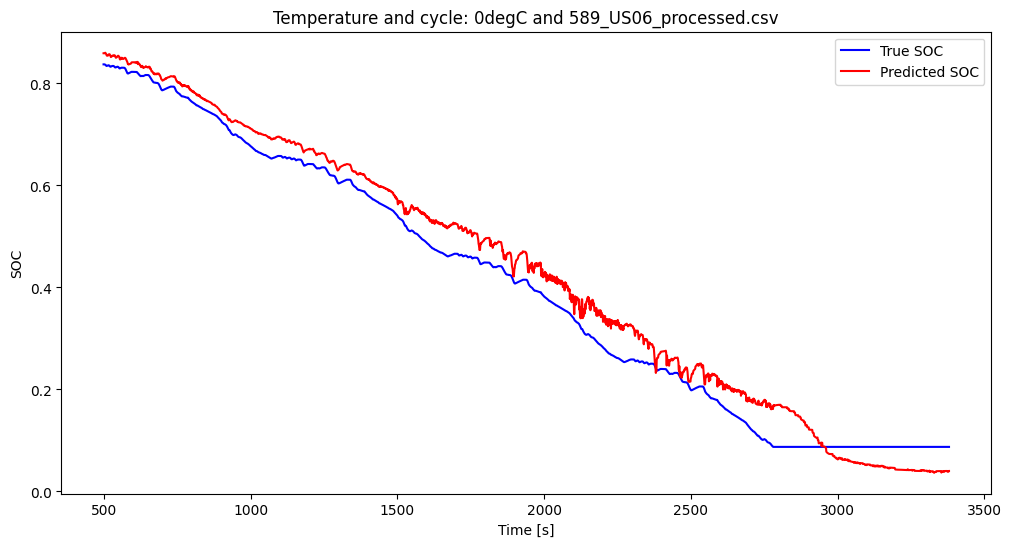


Metrics for 0degC/589_US06_processed.csv:
Test MSE: 0.001762
Test MAE: 0.038752
Test StdDev: 0.031460


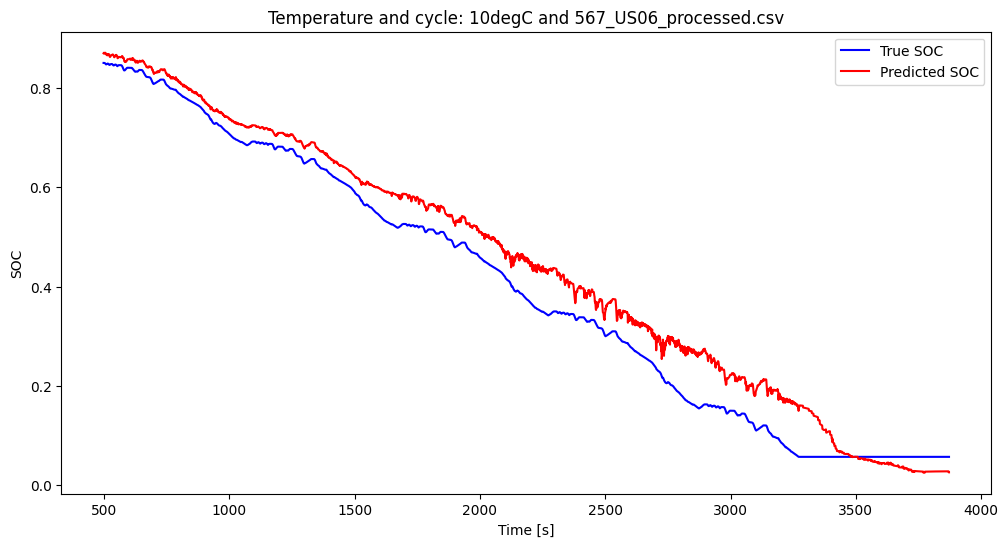


Metrics for 10degC/567_US06_processed.csv:
Test MSE: 0.003118
Test MAE: 0.048862
Test StdDev: 0.033713


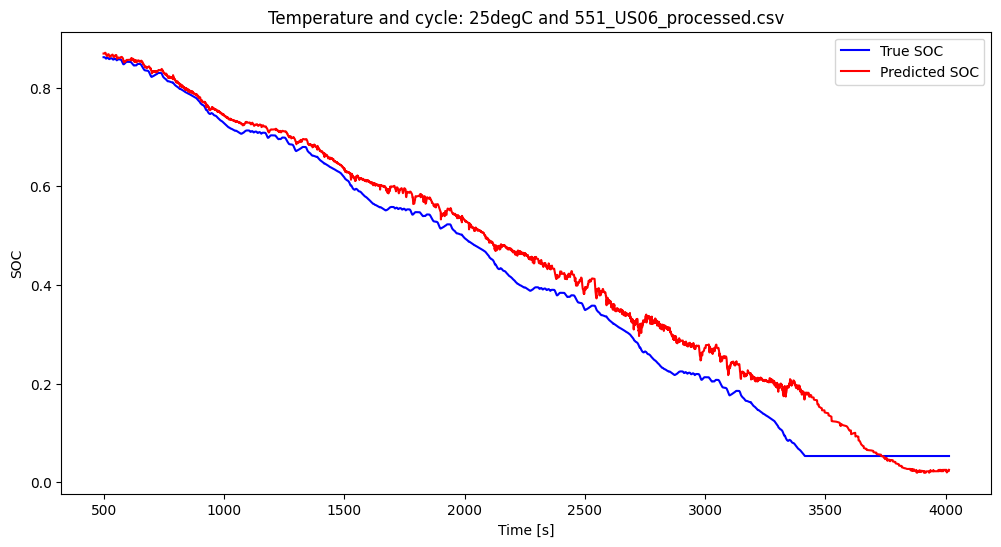


Metrics for 25degC/551_US06_processed.csv:
Test MSE: 0.002255
Test MAE: 0.038751
Test StdDev: 0.032133


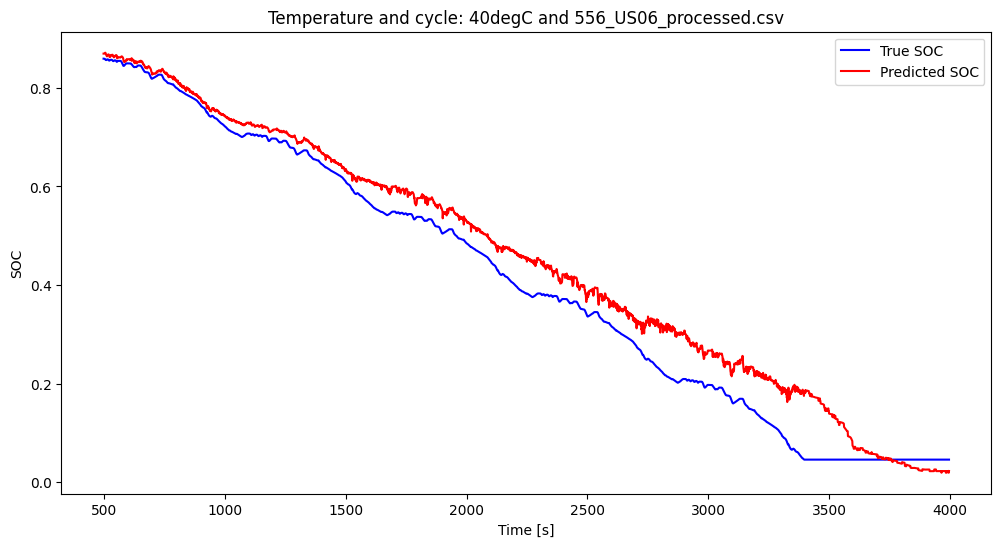


Metrics for 40degC/556_US06_processed.csv:
Test MSE: 0.003014
Test MAE: 0.045220
Test StdDev: 0.034183


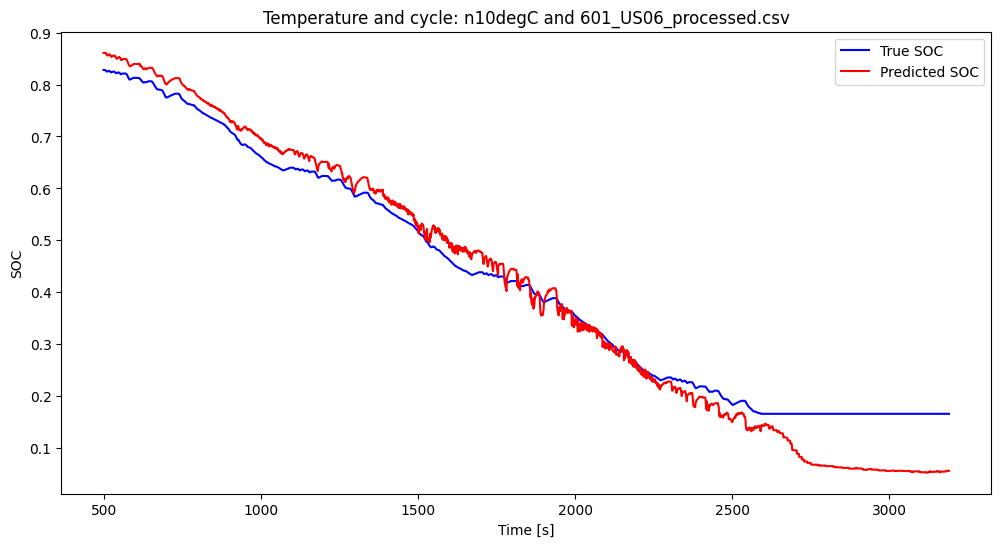


Metrics for n10degC/601_US06_processed.csv:
Test MSE: 0.002572
Test MAE: 0.038323
Test StdDev: 0.049440


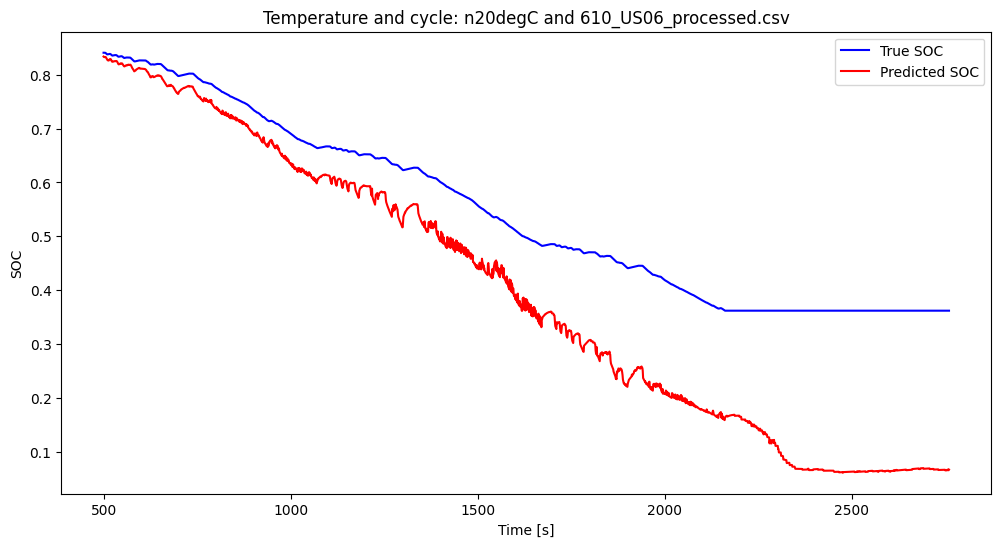


Metrics for n20degC/610_US06_processed.csv:
Test MSE: 0.030903
Test MAE: 0.146223
Test StdDev: 0.097579


In [126]:
metrics_results = evaluate_and_plot(model, collect_data('US06'))

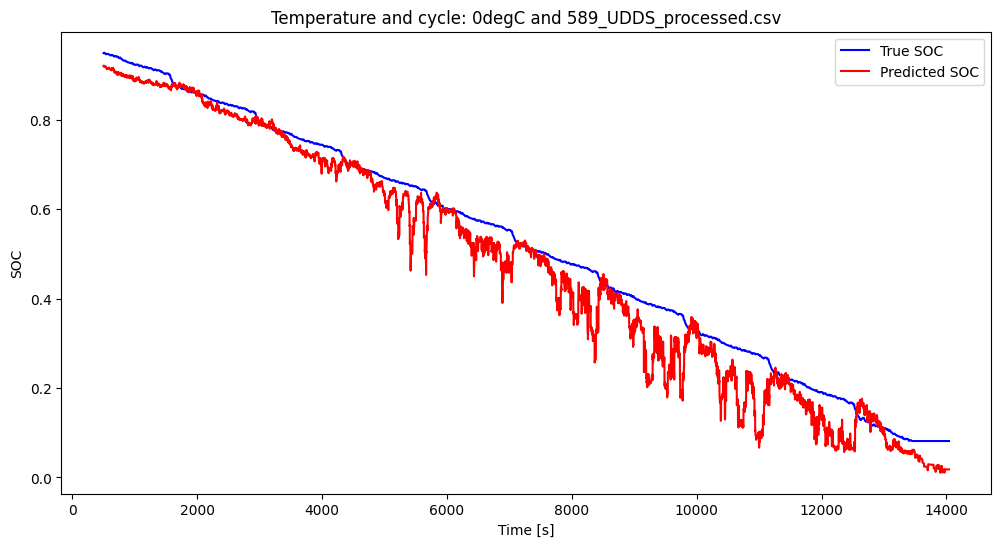


Metrics for 0degC/589_UDDS_processed.csv:
Test MSE: 0.003574
Test MAE: 0.043566
Test StdDev: 0.043066


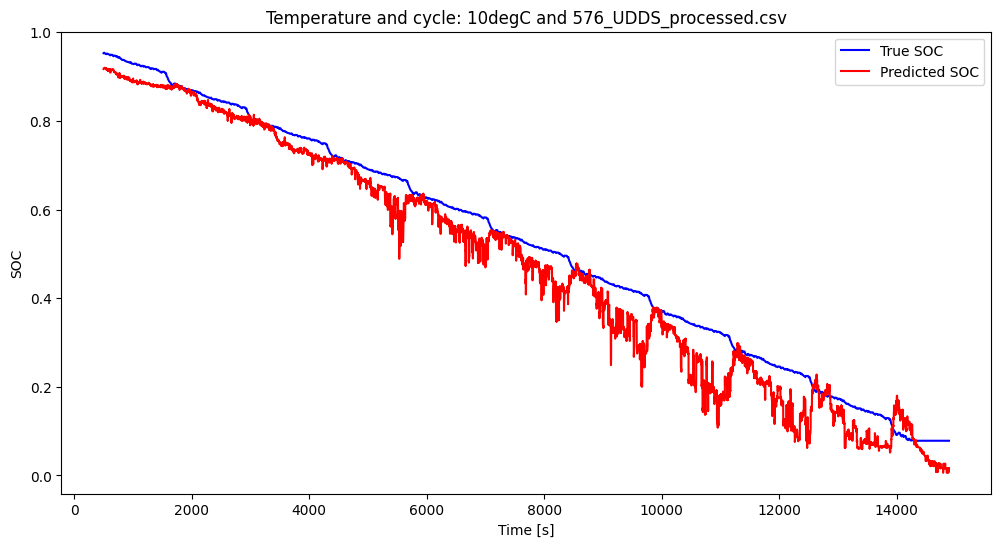


Metrics for 10degC/576_UDDS_processed.csv:
Test MSE: 0.003334
Test MAE: 0.044753
Test StdDev: 0.039380


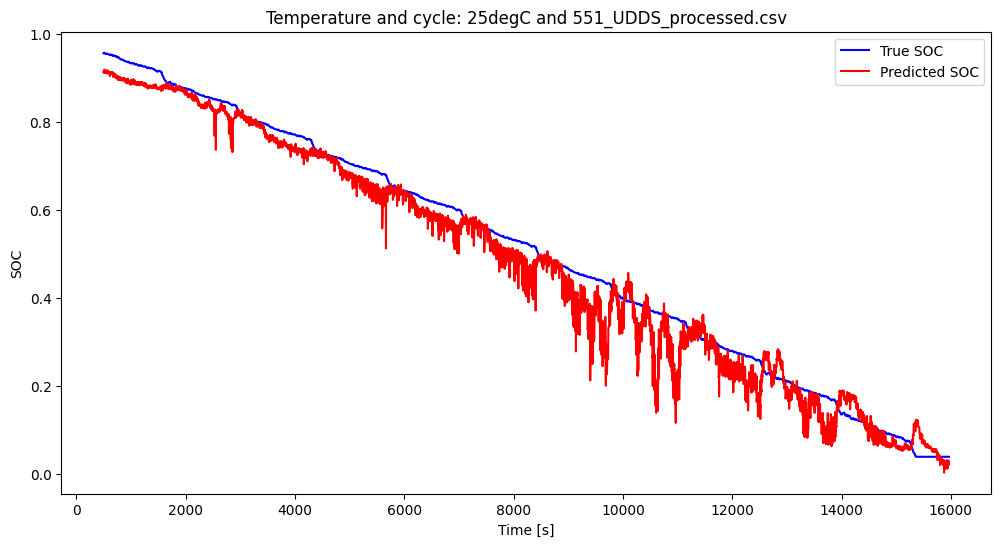


Metrics for 25degC/551_UDDS_processed.csv:
Test MSE: 0.002085
Test MAE: 0.033832
Test StdDev: 0.037554


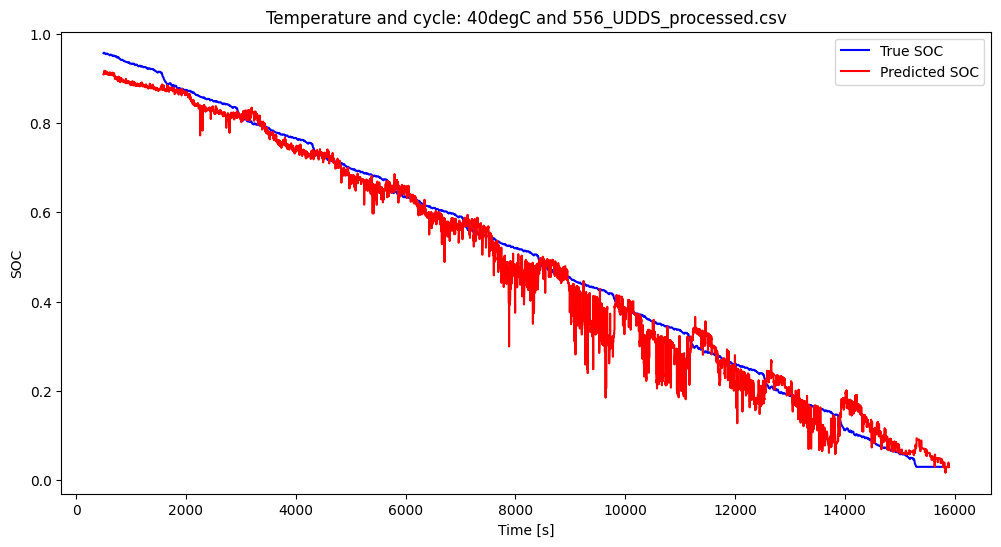


Metrics for 40degC/556_UDDS_processed.csv:
Test MSE: 0.001582
Test MAE: 0.029933
Test StdDev: 0.036494


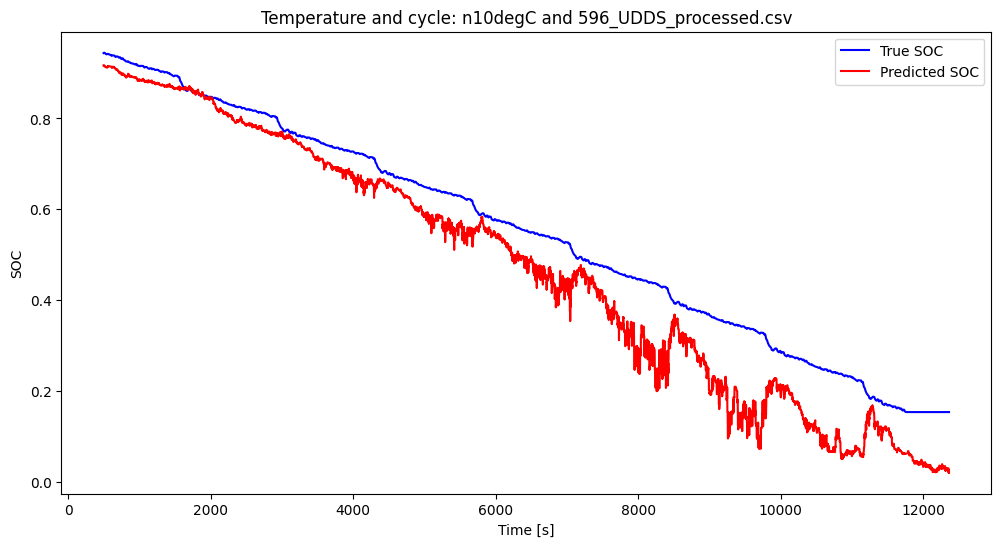


Metrics for n10degC/596_UDDS_processed.csv:
Test MSE: 0.008589
Test MAE: 0.075626
Test StdDev: 0.053724


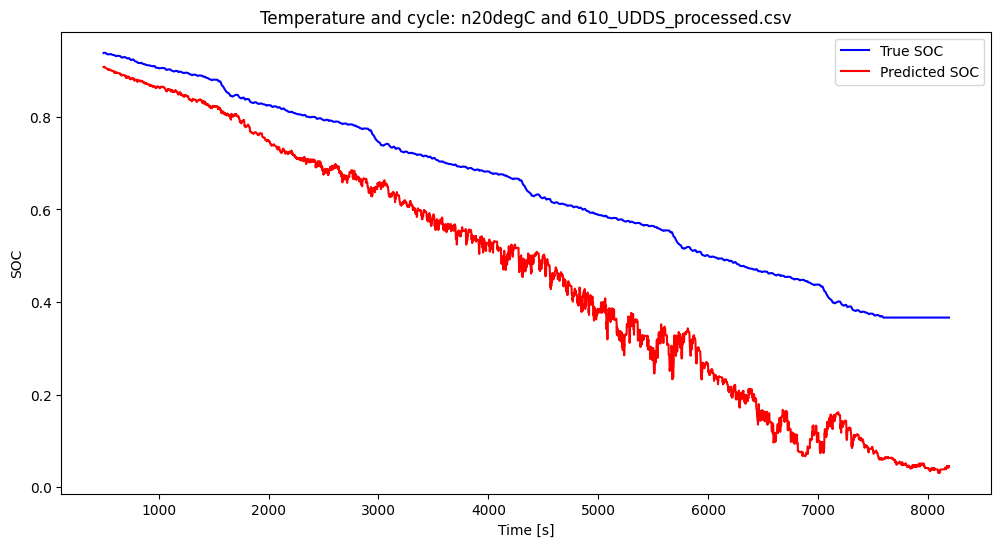


Metrics for n20degC/610_UDDS_processed.csv:
Test MSE: 0.041013
Test MAE: 0.176896
Test StdDev: 0.098595


In [127]:
metrics_results = evaluate_and_plot(model, collect_data('UDDS'))

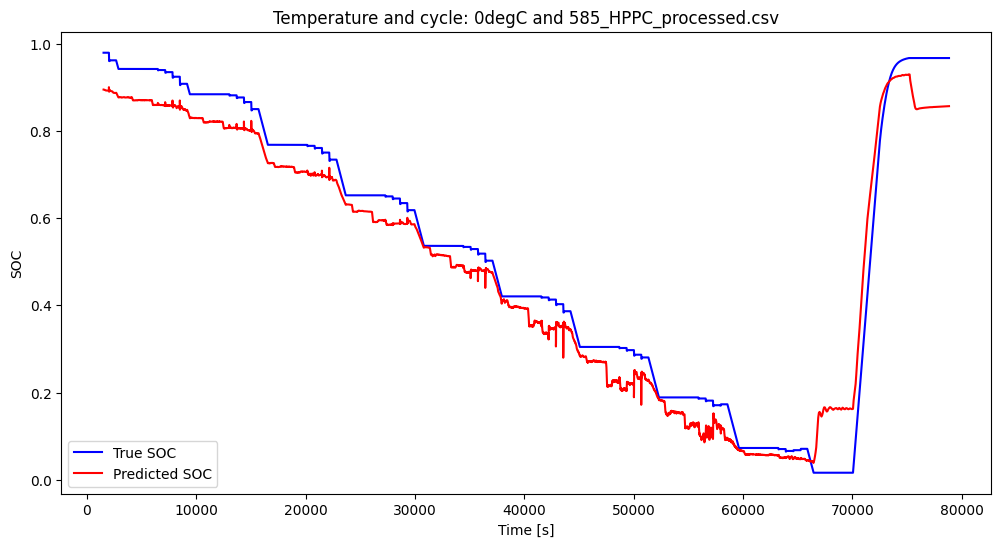


Metrics for 0degC/585_HPPC_processed.csv:
Test MSE: 0.003052
Test MAE: 0.049862
Test StdDev: 0.028732


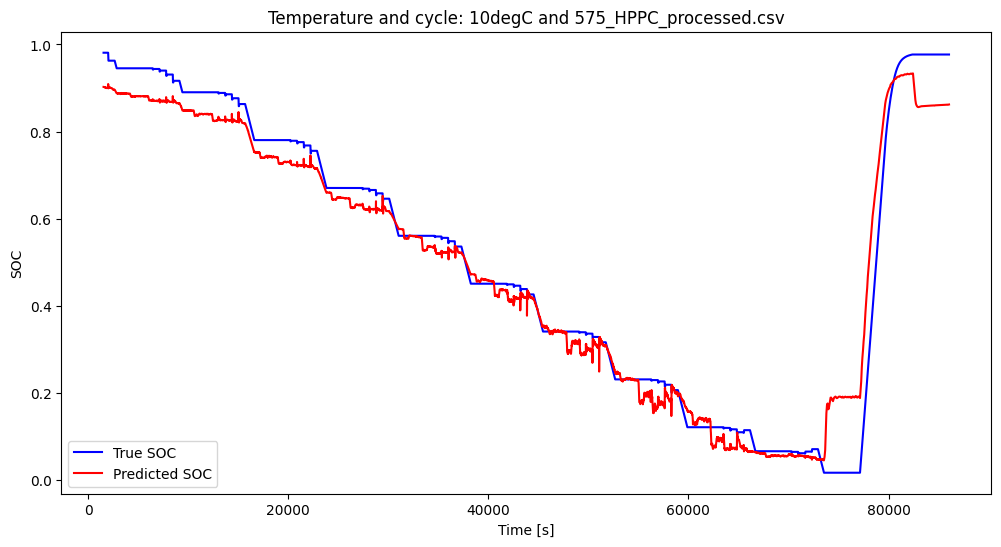


Metrics for 10degC/575_HPPC_processed.csv:
Test MSE: 0.001688
Test MAE: 0.032859
Test StdDev: 0.030880


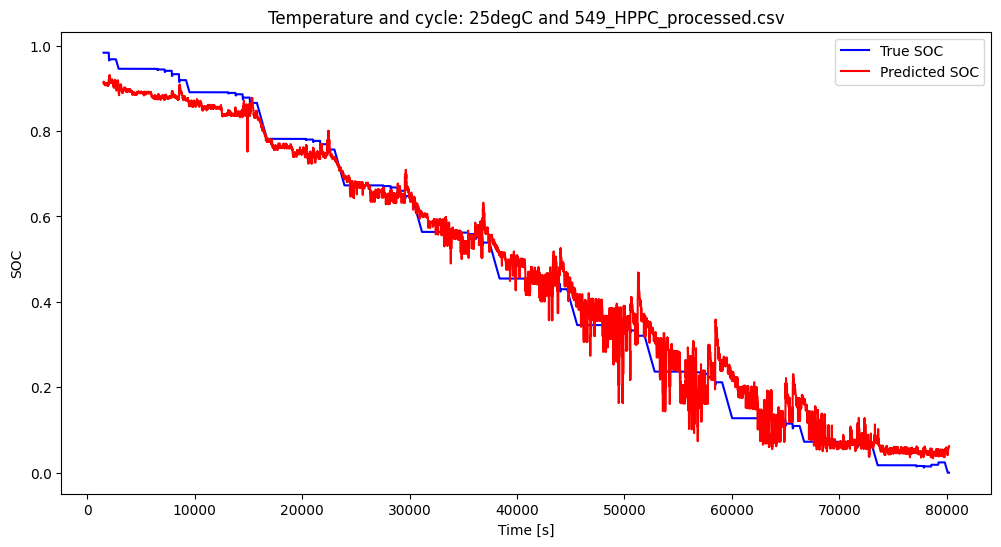


Metrics for 25degC/549_HPPC_processed.csv:
Test MSE: 0.002072
Test MAE: 0.036589
Test StdDev: 0.045226


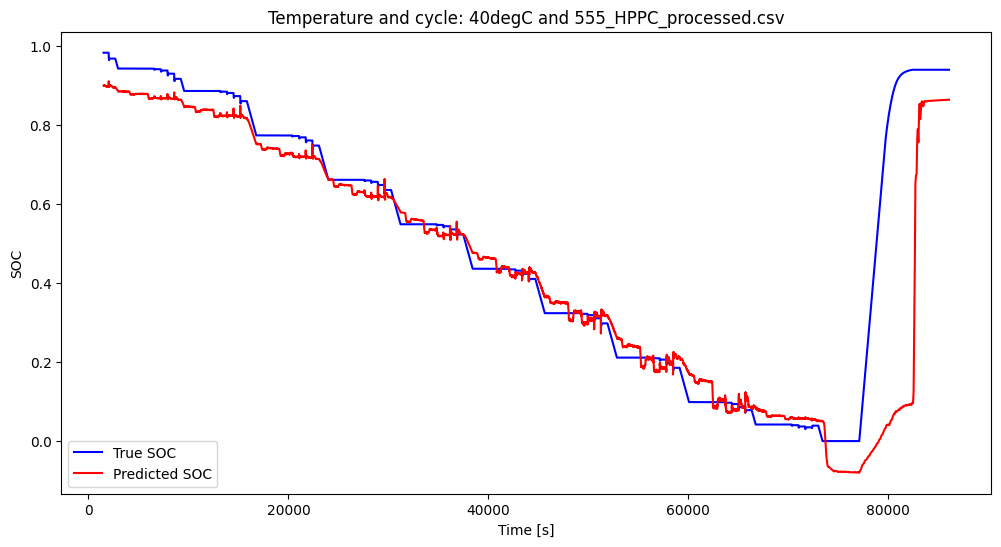


Metrics for 40degC/555_HPPC_processed.csv:
Test MSE: 0.004815
Test MAE: 0.035452
Test StdDev: 0.067316


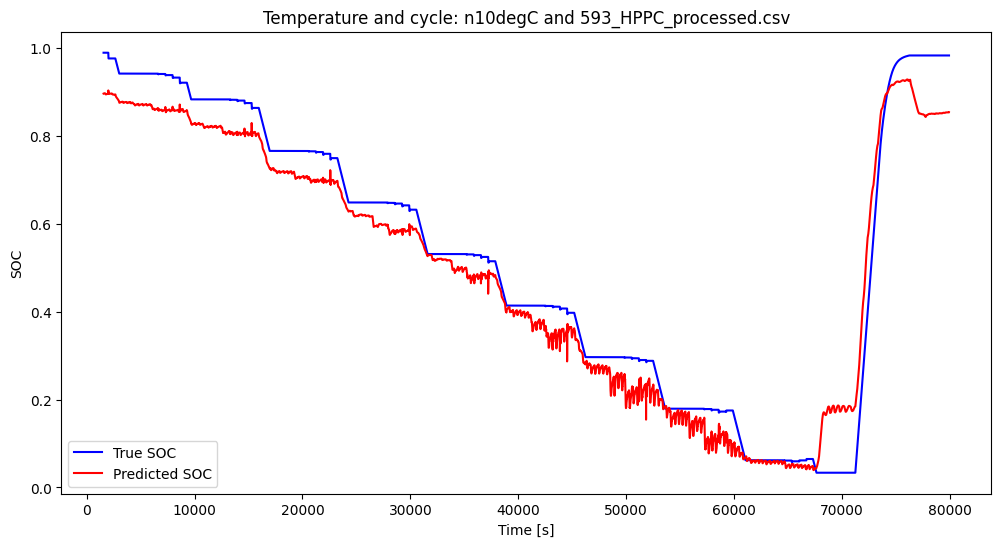


Metrics for n10degC/593_HPPC_processed.csv:
Test MSE: 0.003164
Test MAE: 0.049834
Test StdDev: 0.030309


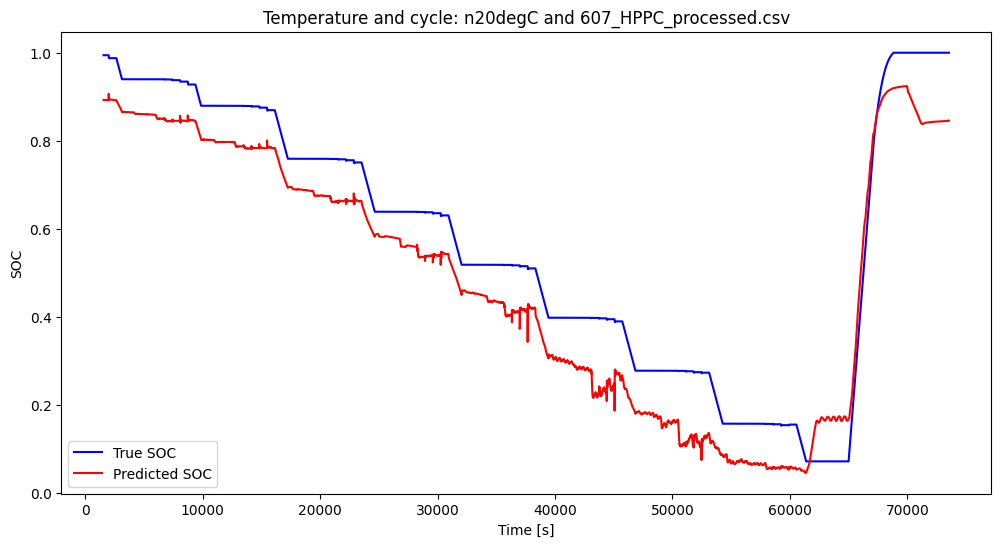


Metrics for n20degC/607_HPPC_processed.csv:
Test MSE: 0.010385
Test MAE: 0.098502
Test StdDev: 0.030963


In [128]:
metrics_results = evaluate_and_plot(model, collect_data('HPPC'))

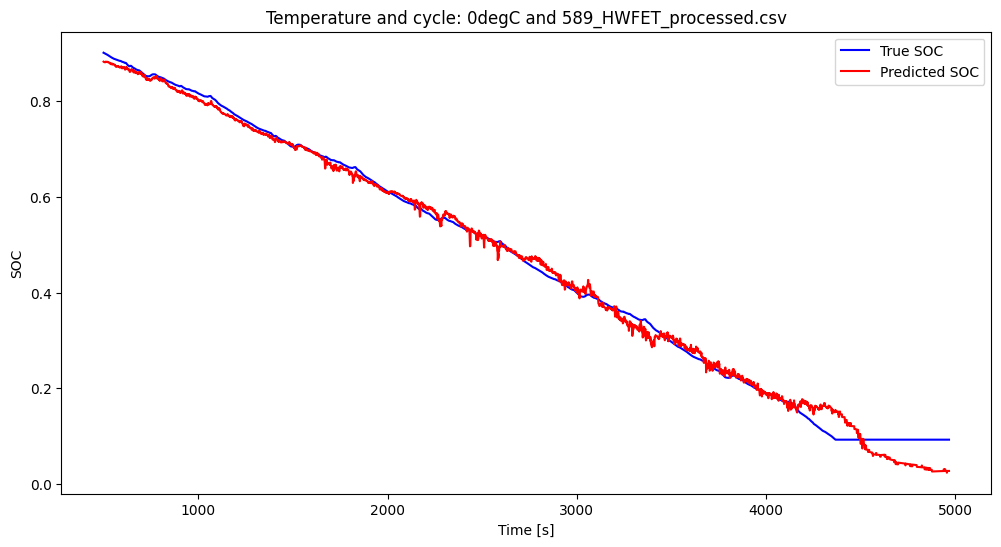


Metrics for 0degC/589_HWFET_processed.csv:
Test MSE: 0.000478
Test MAE: 0.015025
Test StdDev: 0.021542


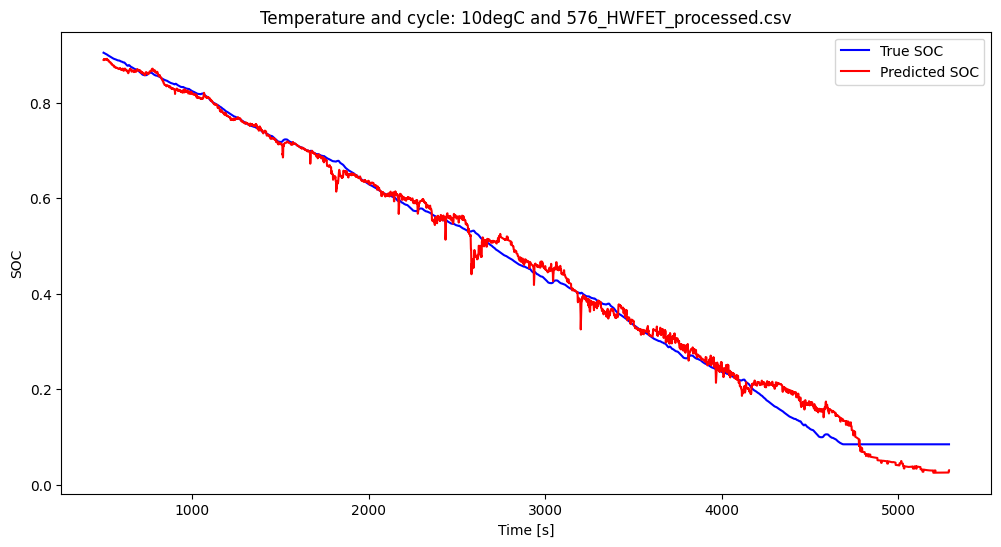


Metrics for 10degC/576_HWFET_processed.csv:
Test MSE: 0.000653
Test MAE: 0.018573
Test StdDev: 0.025441


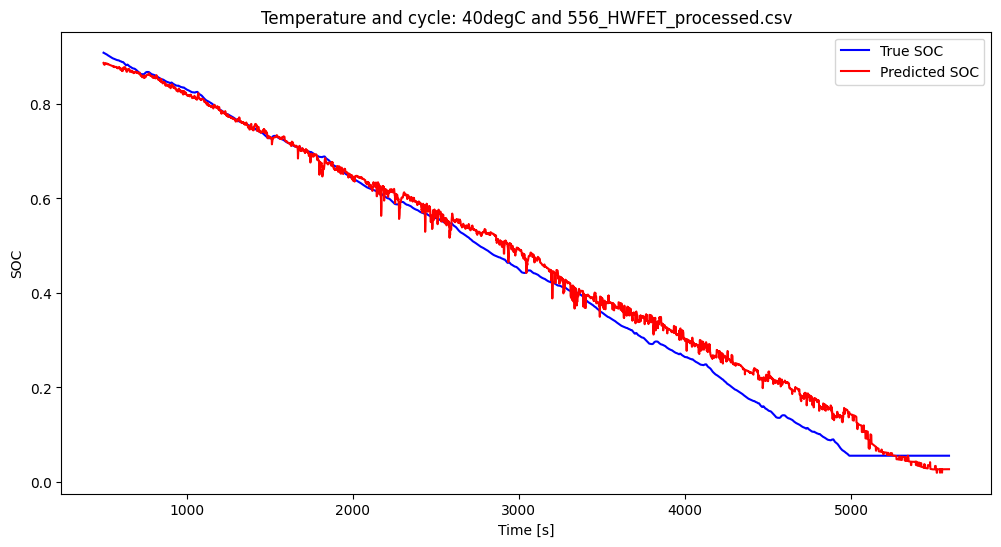


Metrics for 40degC/556_HWFET_processed.csv:
Test MSE: 0.001188
Test MAE: 0.026057
Test StdDev: 0.028162


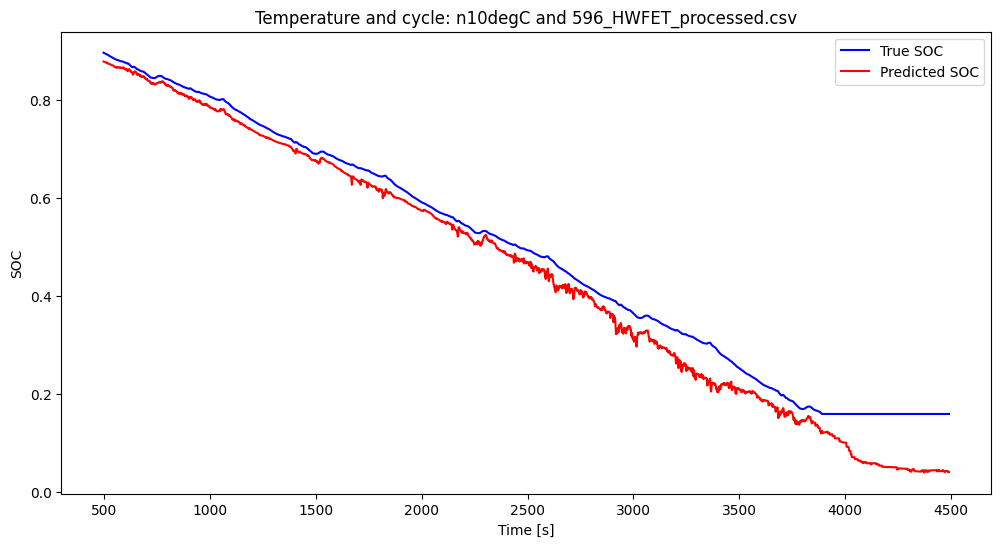


Metrics for n10degC/596_HWFET_processed.csv:
Test MSE: 0.002335
Test MAE: 0.038039
Test StdDev: 0.029800


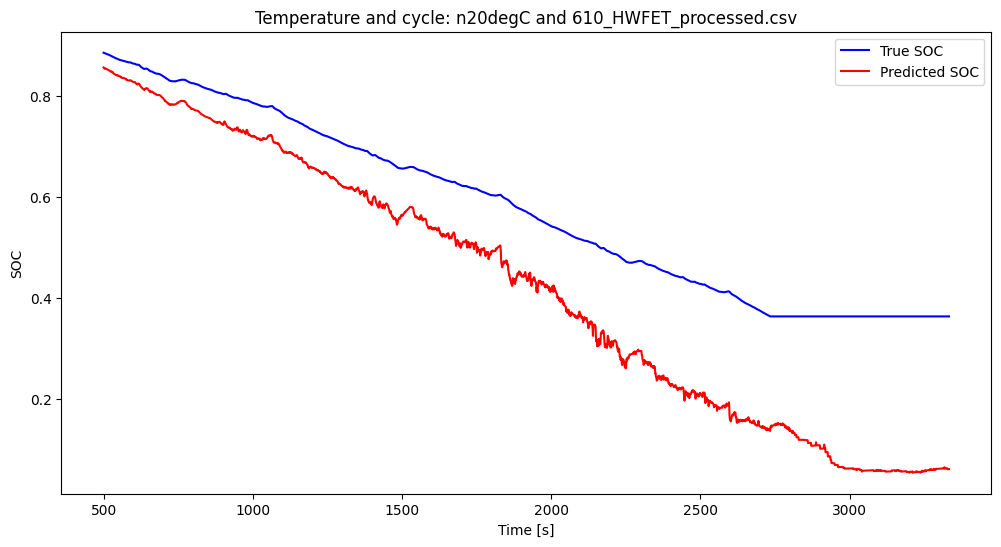


Metrics for n20degC/610_HWFET_processed.csv:
Test MSE: 0.031539
Test MAE: 0.153907
Test StdDev: 0.088612


In [129]:
metrics_results = evaluate_and_plot(model, collect_data('HWFET'))

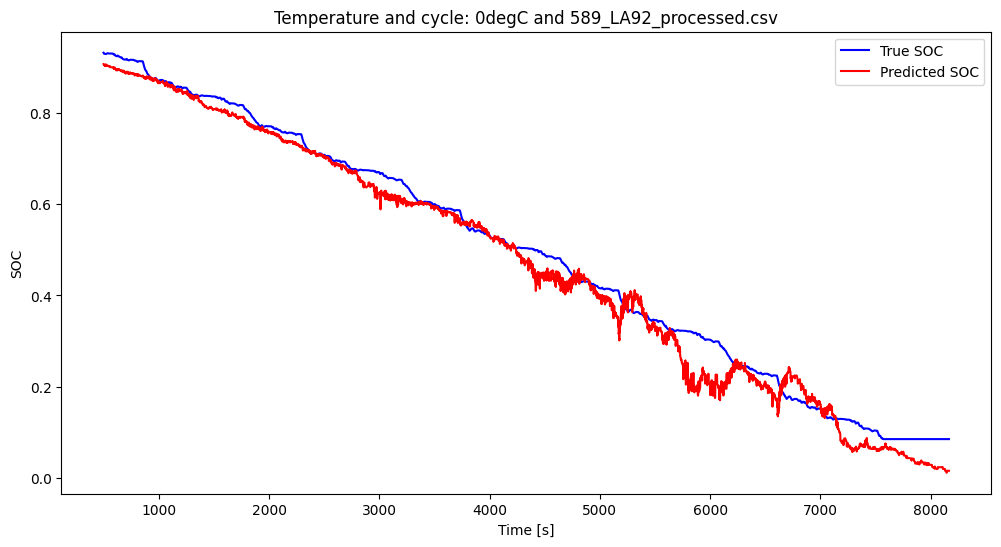


Metrics for 0degC/589_LA92_processed.csv:
Test MSE: 0.001344
Test MAE: 0.027636
Test StdDev: 0.029222


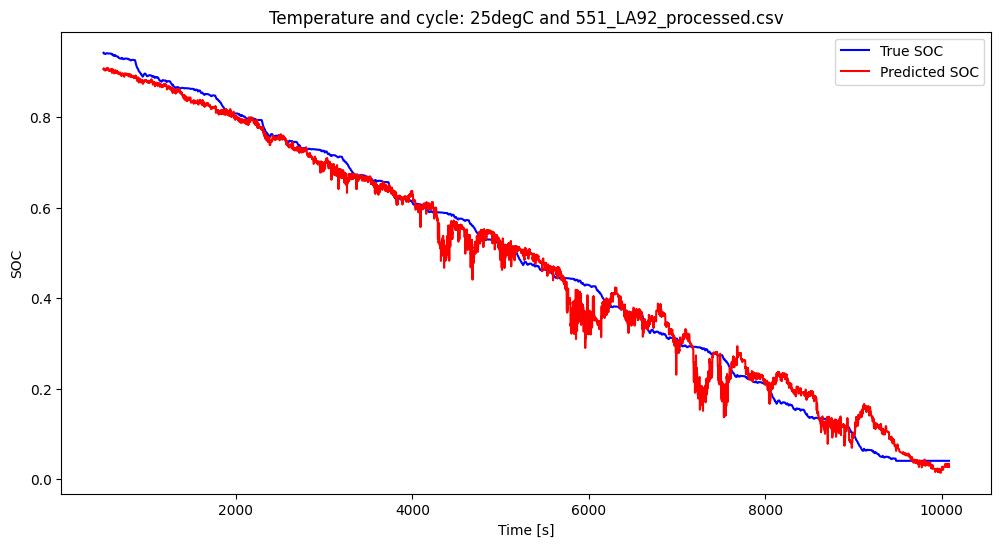


Metrics for 25degC/551_LA92_processed.csv:
Test MSE: 0.001180
Test MAE: 0.025229
Test StdDev: 0.034017


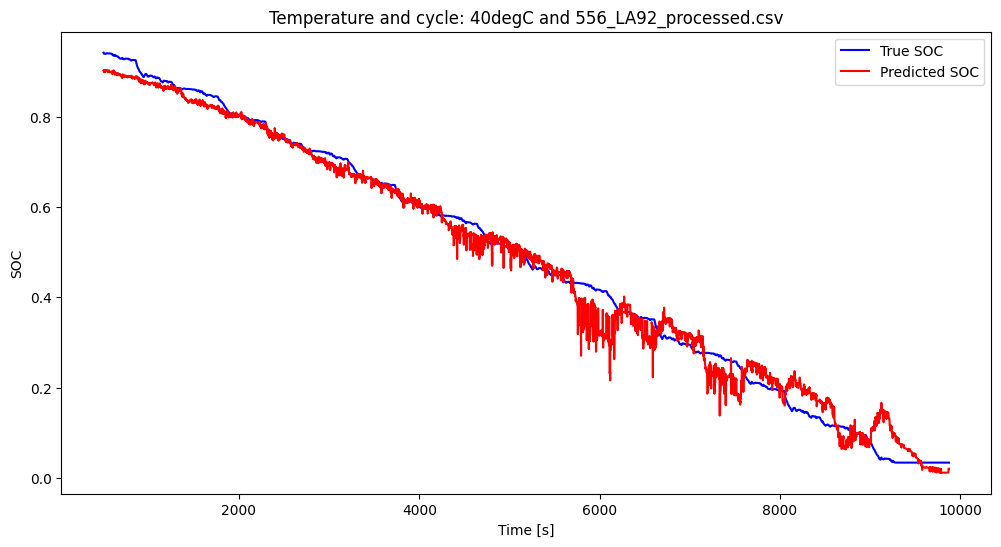


Metrics for 40degC/556_LA92_processed.csv:
Test MSE: 0.001173
Test MAE: 0.025075
Test StdDev: 0.033964


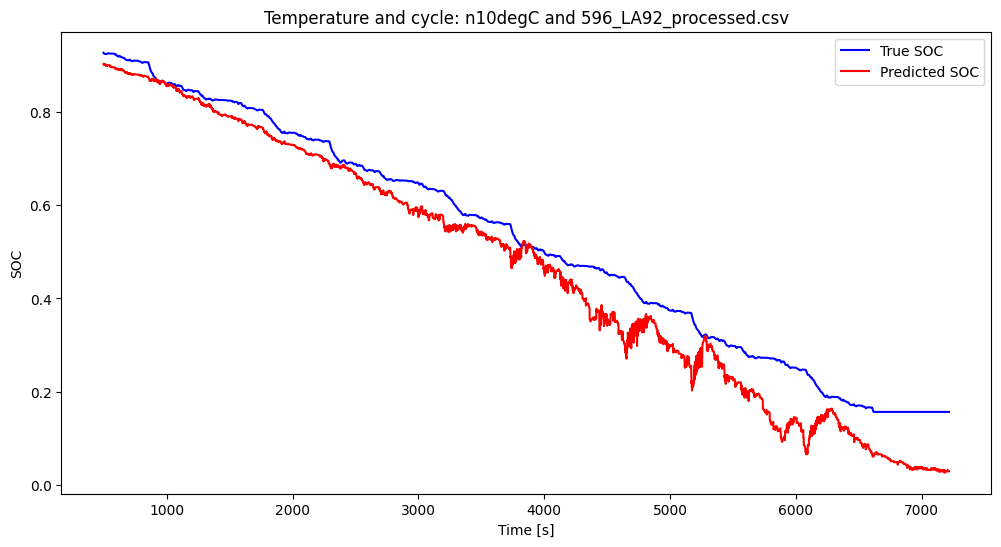


Metrics for n10degC/596_LA92_processed.csv:
Test MSE: 0.004698
Test MAE: 0.056772
Test StdDev: 0.038532


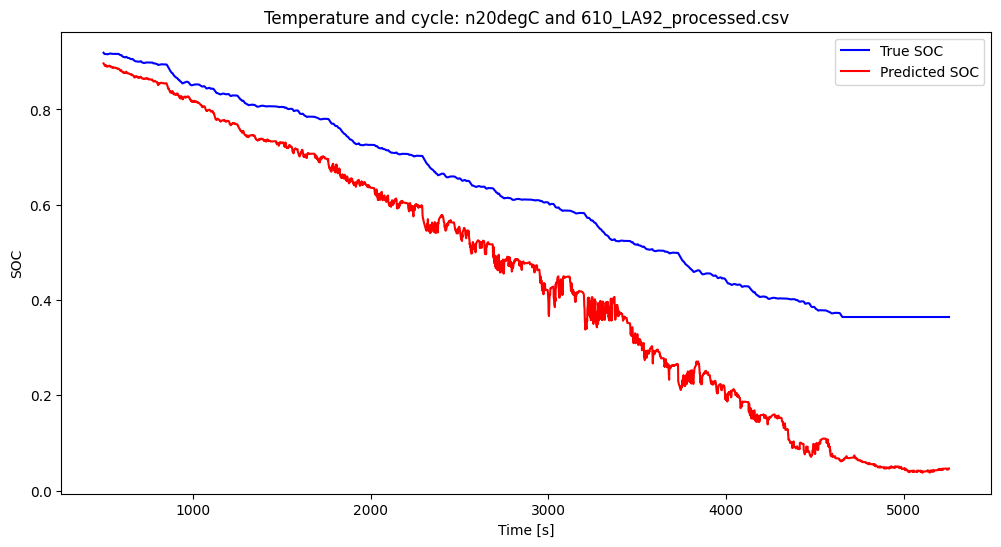


Metrics for n20degC/610_LA92_processed.csv:
Test MSE: 0.035461
Test MAE: 0.162303
Test StdDev: 0.095491


In [130]:
metrics_results = evaluate_and_plot(model, collect_data('LA92'))

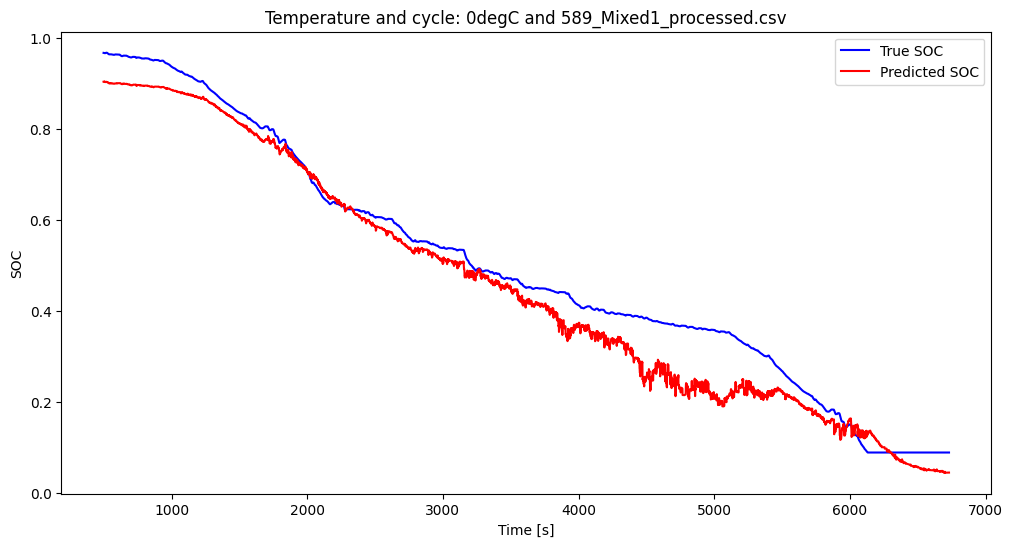


Metrics for 0degC/589_Mixed1_processed.csv:
Test MSE: 0.003569
Test MAE: 0.046707
Test StdDev: 0.040787


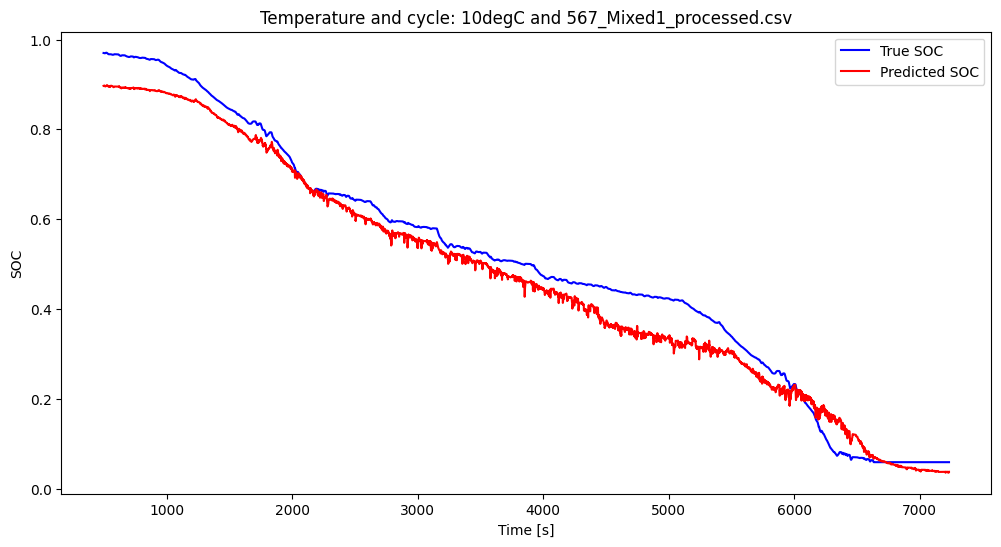


Metrics for 10degC/567_Mixed1_processed.csv:
Test MSE: 0.002254
Test MAE: 0.040792
Test StdDev: 0.033413


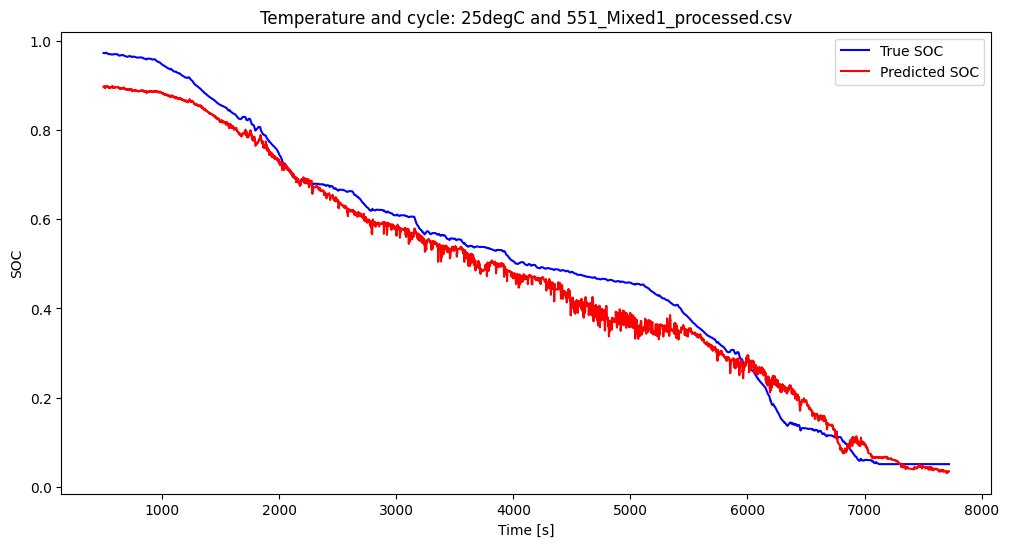


Metrics for 25degC/551_Mixed1_processed.csv:
Test MSE: 0.002080
Test MAE: 0.038328
Test StdDev: 0.036901


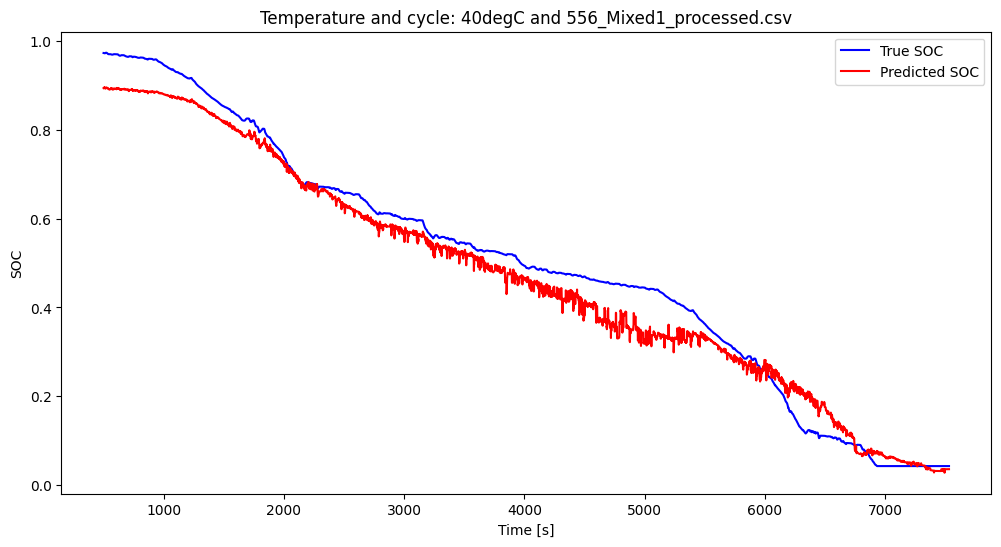


Metrics for 40degC/556_Mixed1_processed.csv:
Test MSE: 0.002410
Test MAE: 0.040870
Test StdDev: 0.039597


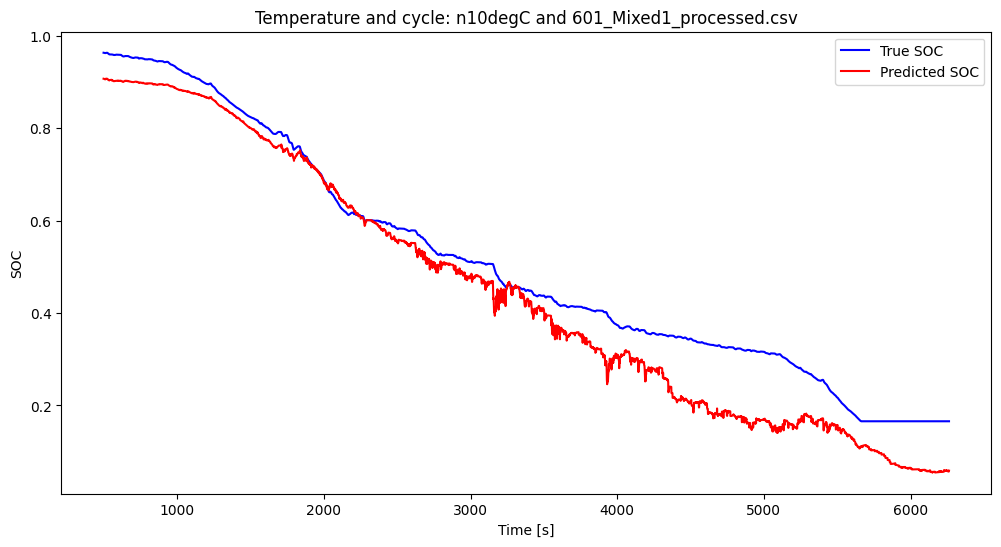


Metrics for n10degC/601_Mixed1_processed.csv:
Test MSE: 0.005888
Test MAE: 0.062522
Test StdDev: 0.045990


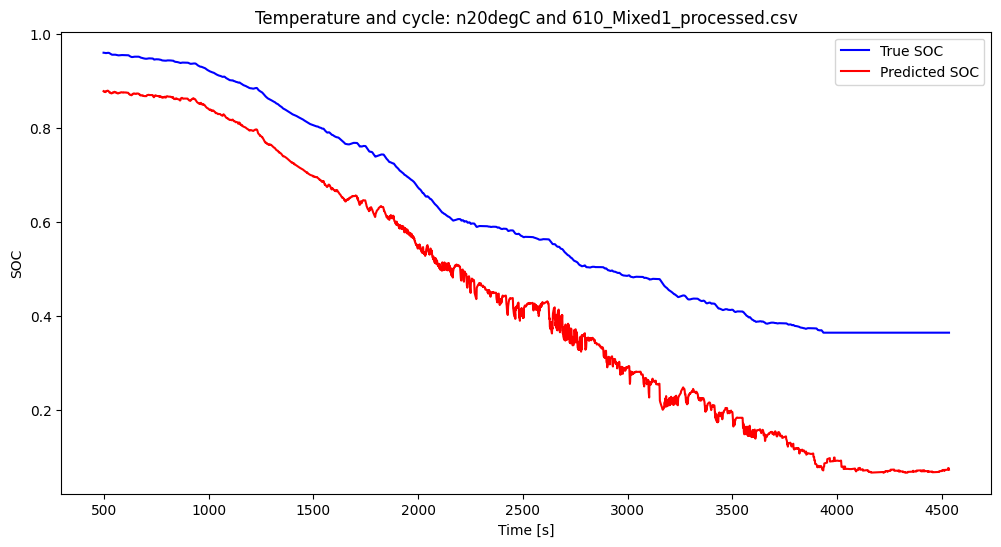


Metrics for n20degC/610_Mixed1_processed.csv:
Test MSE: 0.034334
Test MAE: 0.169449
Test StdDev: 0.074974


In [134]:
metrics_results = evaluate_and_plot(model, collect_data('Mixed1'))

### DNN inference, model which was build on LG dataset are testing on Panasonic dataset

In [138]:
FEATURE_COLS_LG = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Power [W]', 'Cumulative_Capacity_Ah']
hidden_size = 128
num_layers = 2
input_size = len(FEATURE_COLS_LG)
dropout = 0.2675

model_path = "../training_and_testing/for_lg_data/soc_dnn_model.pth"
model = load_model(model_path, input_size, hidden_size, num_layers, dropout)

In [148]:
def collect_data_panasonic(cycle_name):
    results = defaultdict(dict)

    base_path = '../datasets/Panasonic_dataset/Panasonic_processed'


    temp_folders = ['0degC', '10degC', '25degC', 'n10degC', 'n20degC']


    for temp_folder in temp_folders:
        folder_path = os.path.join(base_path, temp_folder)

        for file in os.listdir(folder_path):
            if cycle_name in file and file.endswith('.csv'):
                file_path = os.path.join(folder_path, file)
                

                test_df = pd.read_csv(file_path)
                test_df['Power [W]'] = test_df['Voltage [V]'] * test_df['Current [A]']
                
                scaler = StandardScaler()
                test_df[FEATURE_COLS_LG] = scaler.fit_transform(test_df[FEATURE_COLS_LG])
                
                test_tensor = torch.tensor(test_df[FEATURE_COLS_LG].values, dtype=torch.float32)
                test_labels = torch.tensor(test_df[LABEL_COL].values, dtype=torch.float32)
                
                results[temp_folder][file] = {
                    'dataframe': test_df,
                    'tensor': test_tensor,
                    'labels': test_labels,
                    'scaler': scaler
                }
    return results

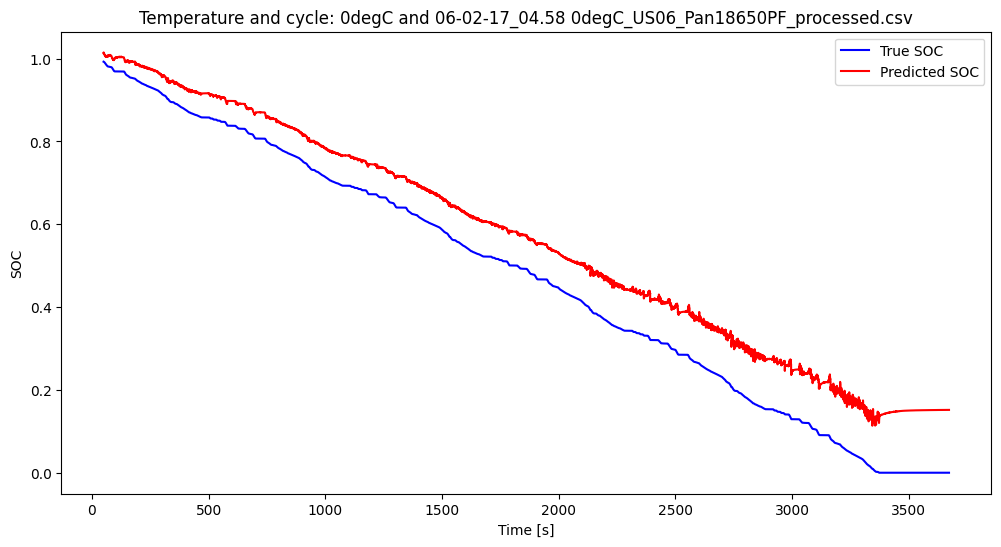


Metrics for 0degC/06-02-17_04.58 0degC_US06_Pan18650PF_processed.csv:
Test MSE: 0.009035
Test MAE: 0.089808
Test StdDev: 0.031142


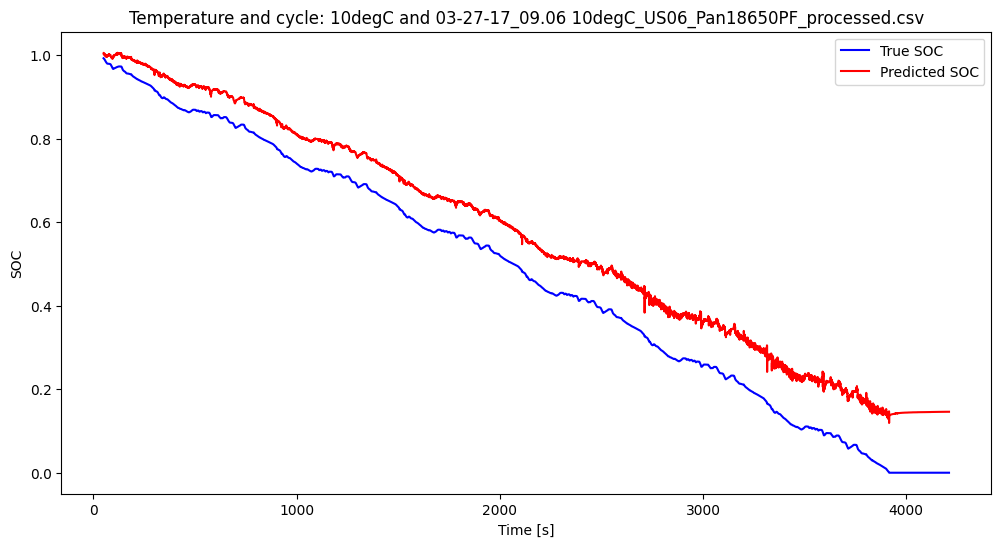


Metrics for 10degC/03-27-17_09.06 10degC_US06_Pan18650PF_processed.csv:
Test MSE: 0.008953
Test MAE: 0.090190
Test StdDev: 0.028619


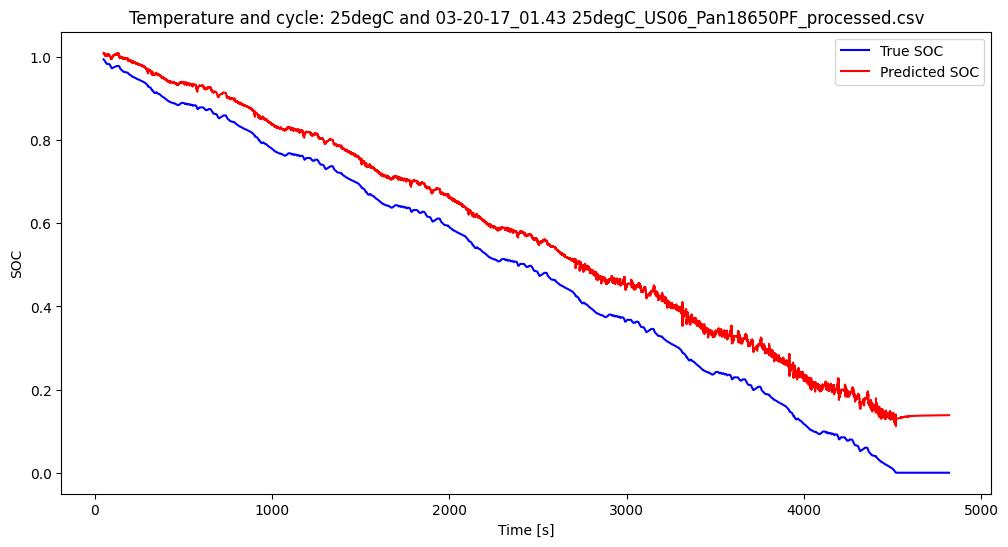


Metrics for 25degC/03-20-17_01.43 25degC_US06_Pan18650PF_processed.csv:
Test MSE: 0.007355
Test MAE: 0.081355
Test StdDev: 0.027139


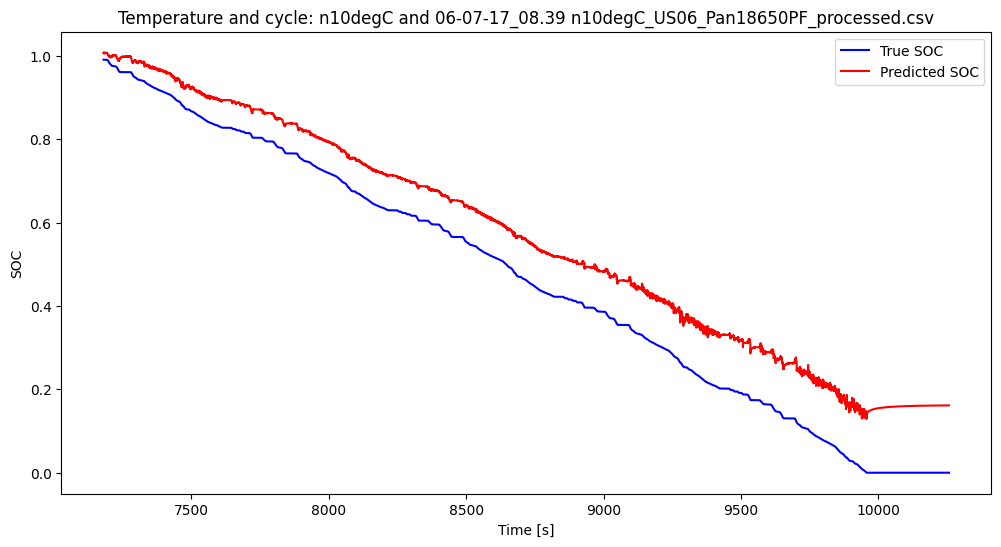


Metrics for n10degC/06-07-17_08.39 n10degC_US06_Pan18650PF_processed.csv:
Test MSE: 0.010645
Test MAE: 0.097322
Test StdDev: 0.034260


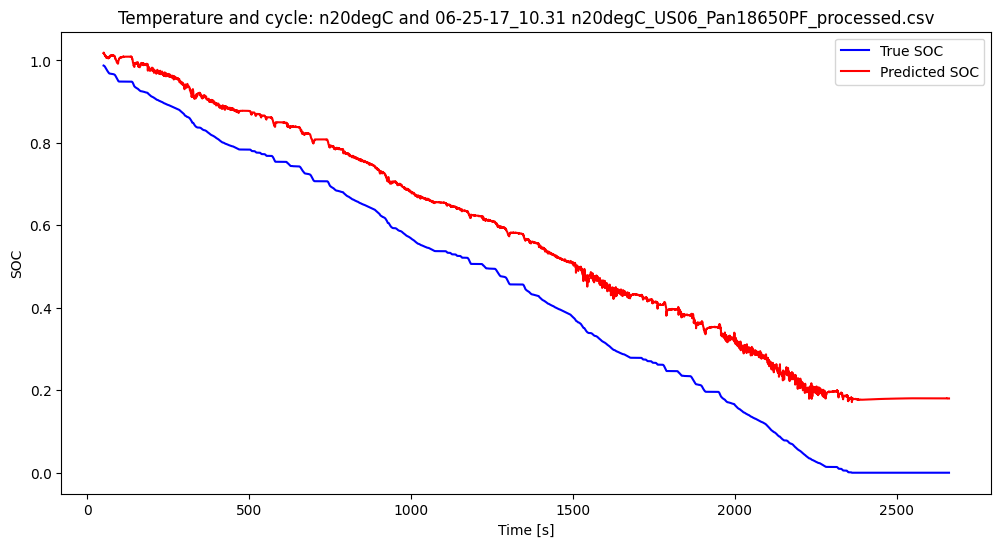


Metrics for n20degC/06-25-17_10.31 n20degC_US06_Pan18650PF_processed.csv:
Test MSE: 0.017323
Test MAE: 0.126231
Test StdDev: 0.037271


In [149]:
metrics_results = evaluate_and_plot(model, collect_data_panasonic('US06'))

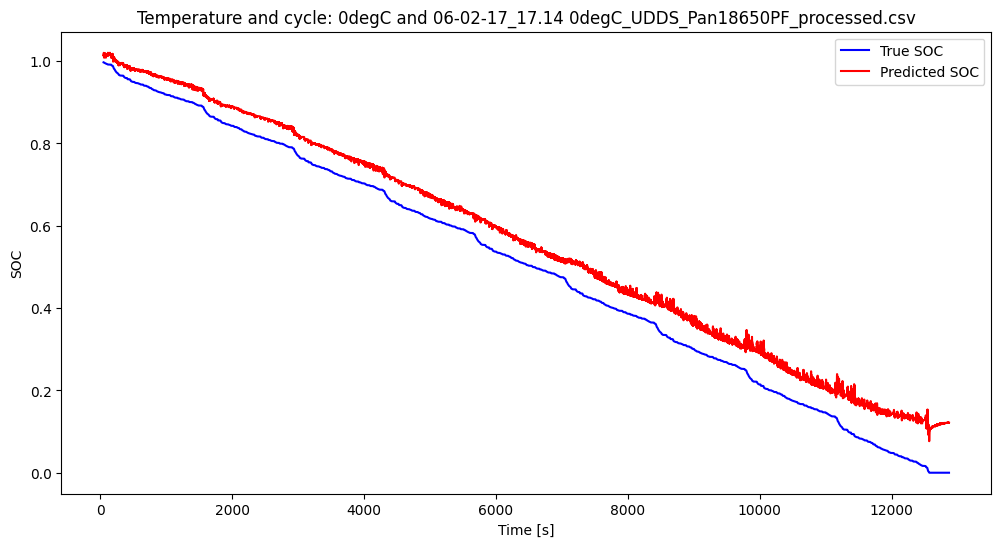


Metrics for 0degC/06-02-17_17.14 0degC_UDDS_Pan18650PF_processed.csv:
Test MSE: 0.003902
Test MAE: 0.059234
Test StdDev: 0.019831


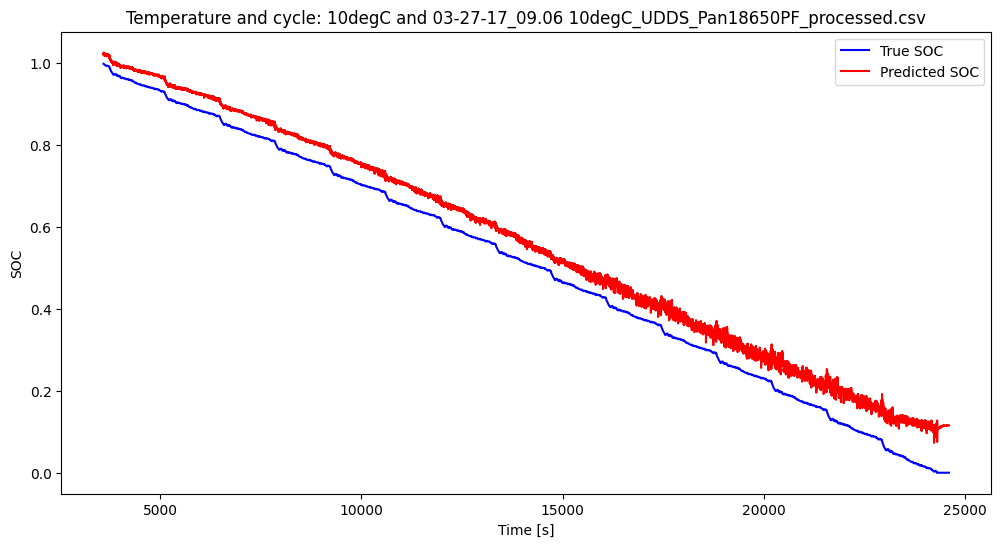


Metrics for 10degC/03-27-17_09.06 10degC_UDDS_Pan18650PF_processed.csv:
Test MSE: 0.003250
Test MAE: 0.054114
Test StdDev: 0.017947


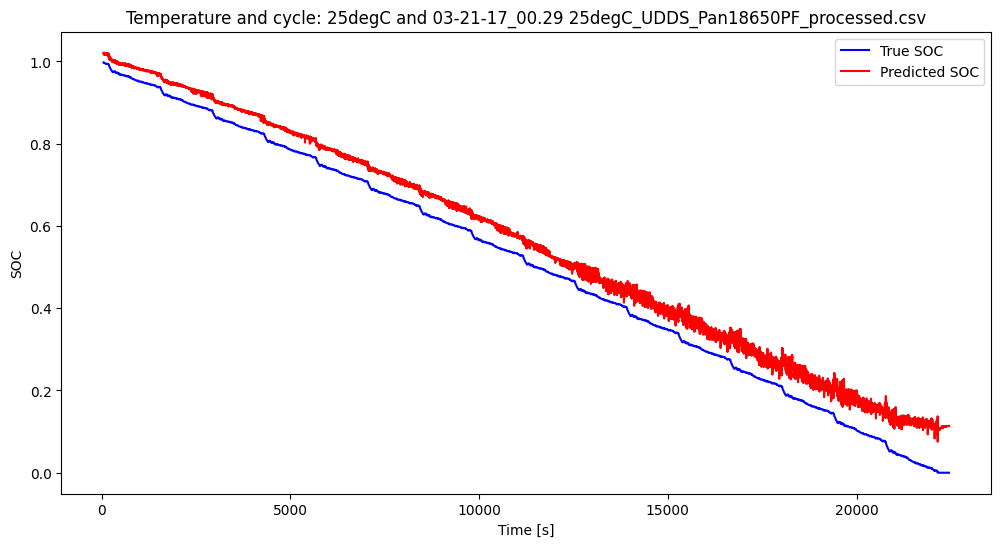


Metrics for 25degC/03-21-17_00.29 25degC_UDDS_Pan18650PF_processed.csv:
Test MSE: 0.003088
Test MAE: 0.052462
Test StdDev: 0.018313


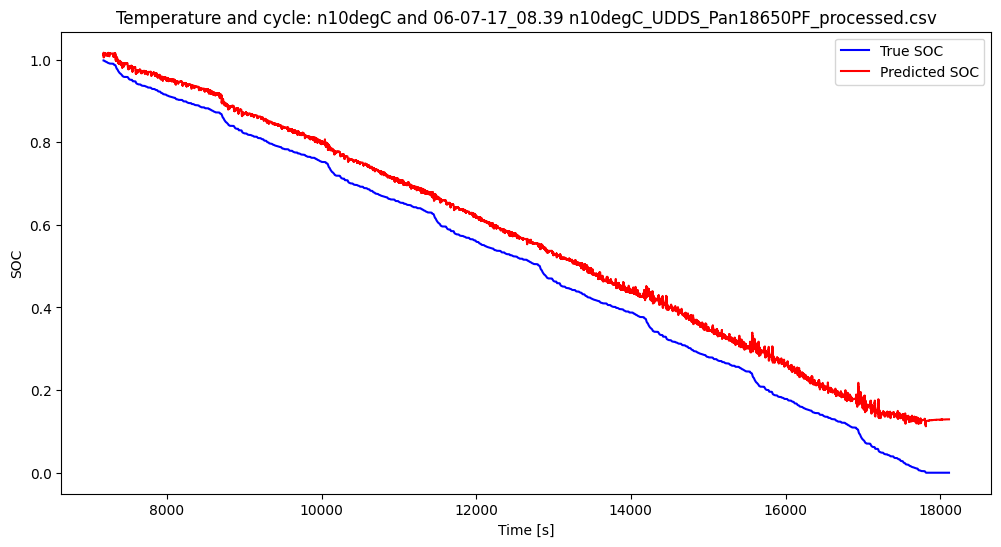


Metrics for n10degC/06-07-17_08.39 n10degC_UDDS_Pan18650PF_processed.csv:
Test MSE: 0.004426
Test MAE: 0.062861
Test StdDev: 0.021782


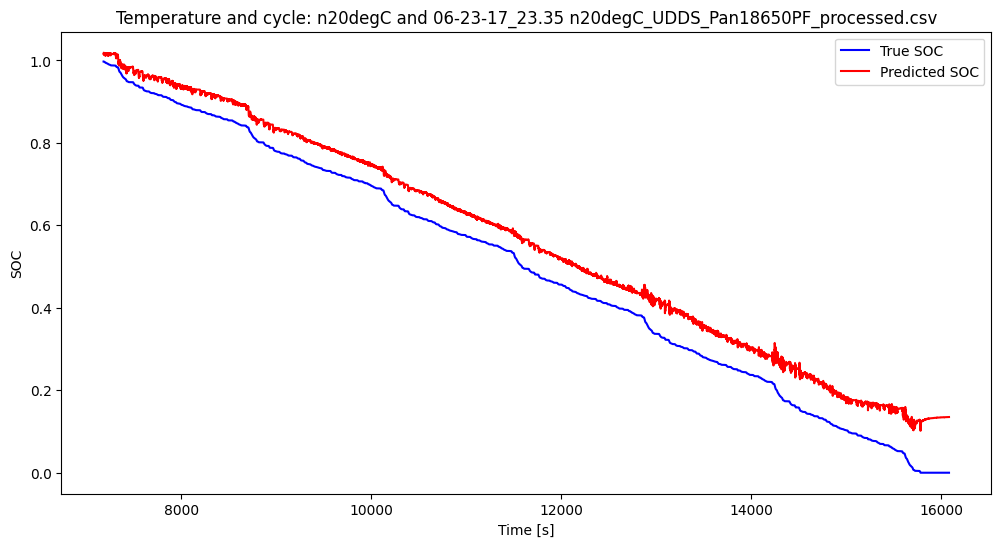


Metrics for n20degC/06-23-17_23.35 n20degC_UDDS_Pan18650PF_processed.csv:
Test MSE: 0.004670
Test MAE: 0.064895
Test StdDev: 0.021405


In [150]:
metrics_results = evaluate_and_plot(model, collect_data_panasonic('UDDS'))

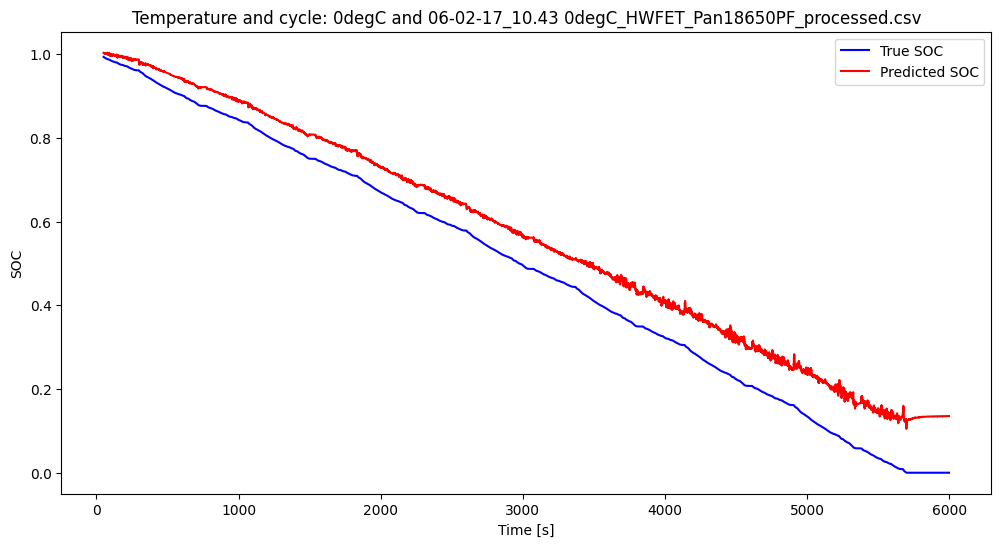


Metrics for 0degC/06-02-17_10.43 0degC_HWFET_Pan18650PF_processed.csv:
Test MSE: 0.006327
Test MAE: 0.074200
Test StdDev: 0.028667


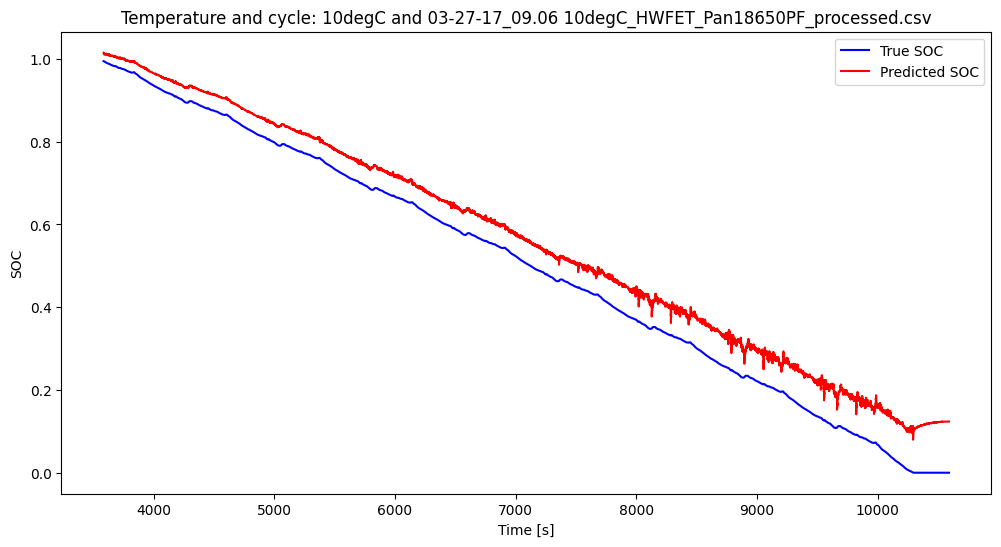


Metrics for 10degC/03-27-17_09.06 10degC_HWFET_Pan18650PF_processed.csv:
Test MSE: 0.004217
Test MAE: 0.061046
Test StdDev: 0.022143


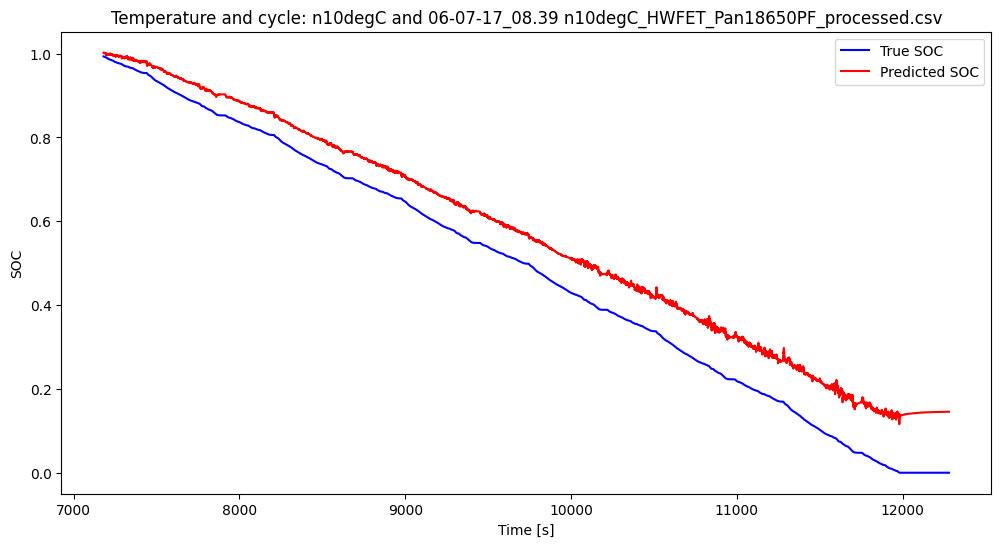


Metrics for n10degC/06-07-17_08.39 n10degC_HWFET_Pan18650PF_processed.csv:
Test MSE: 0.007283
Test MAE: 0.079202
Test StdDev: 0.031788


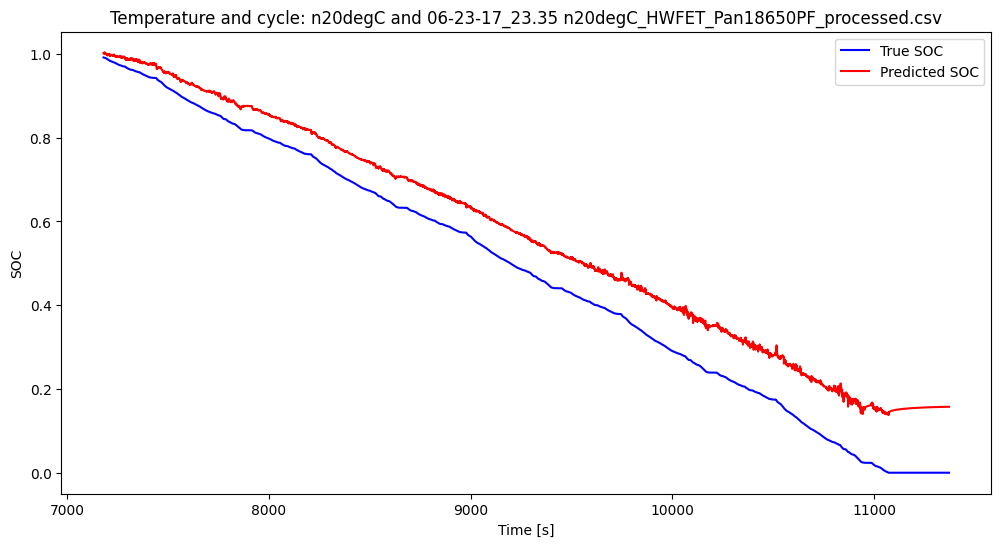


Metrics for n20degC/06-23-17_23.35 n20degC_HWFET_Pan18650PF_processed.csv:
Test MSE: 0.008458
Test MAE: 0.085124
Test StdDev: 0.034810


In [151]:
metrics_results = evaluate_and_plot(model, collect_data_panasonic('HWFET'))

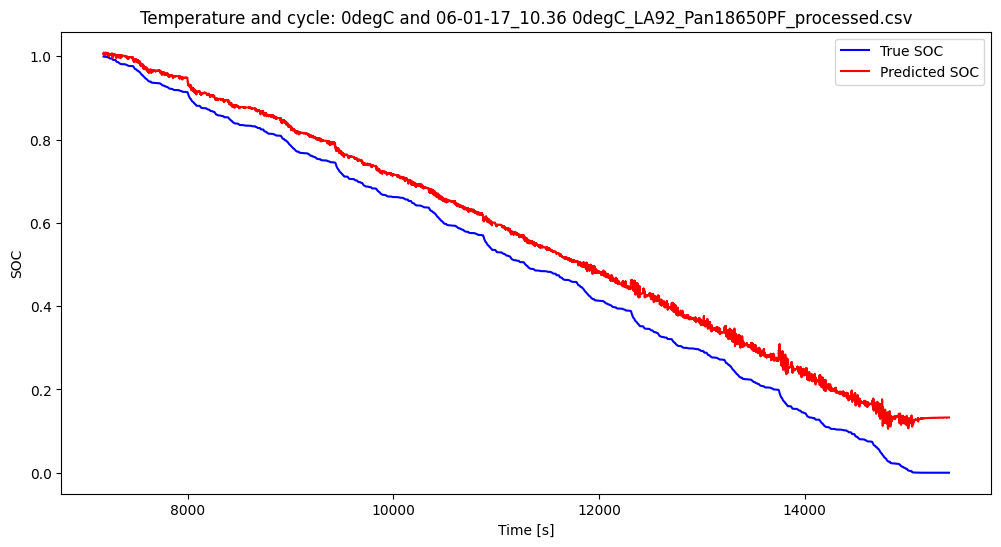


Metrics for 0degC/06-01-17_10.36 0degC_LA92_Pan18650PF_processed.csv:
Test MSE: 0.004781
Test MAE: 0.063749
Test StdDev: 0.026786


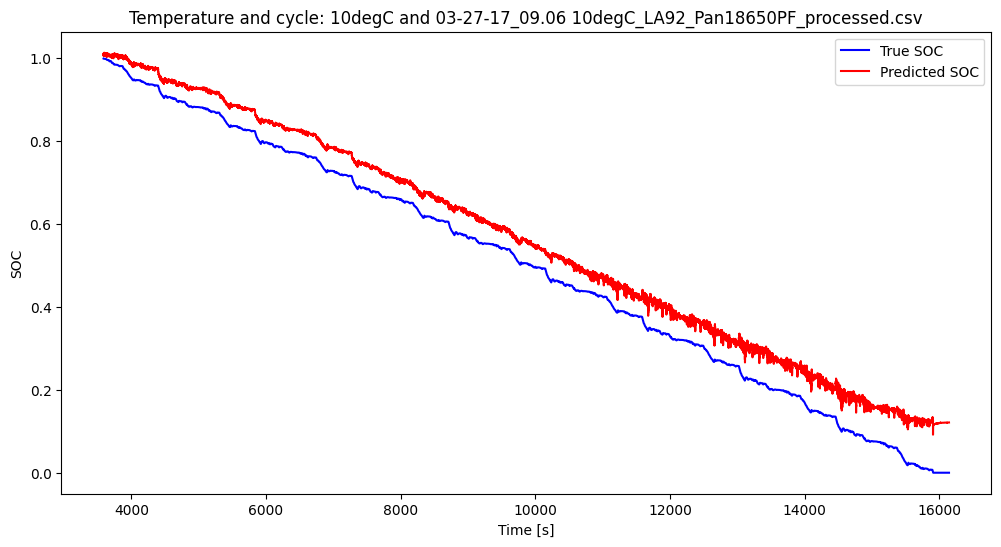


Metrics for 10degC/03-27-17_09.06 10degC_LA92_Pan18650PF_processed.csv:
Test MSE: 0.003992
Test MAE: 0.060027
Test StdDev: 0.019707


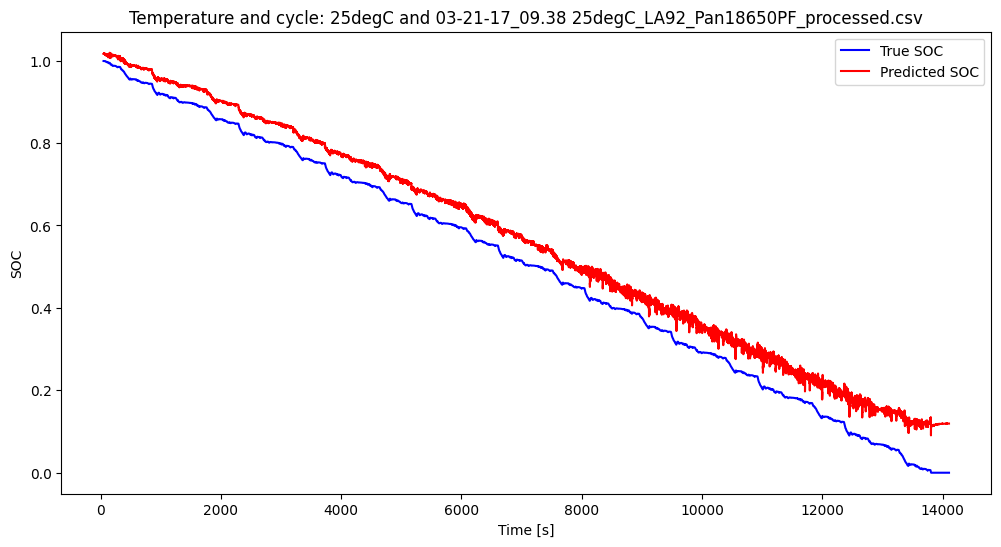


Metrics for 25degC/03-21-17_09.38 25degC_LA92_Pan18650PF_processed.csv:
Test MSE: 0.003786
Test MAE: 0.058372
Test StdDev: 0.019451


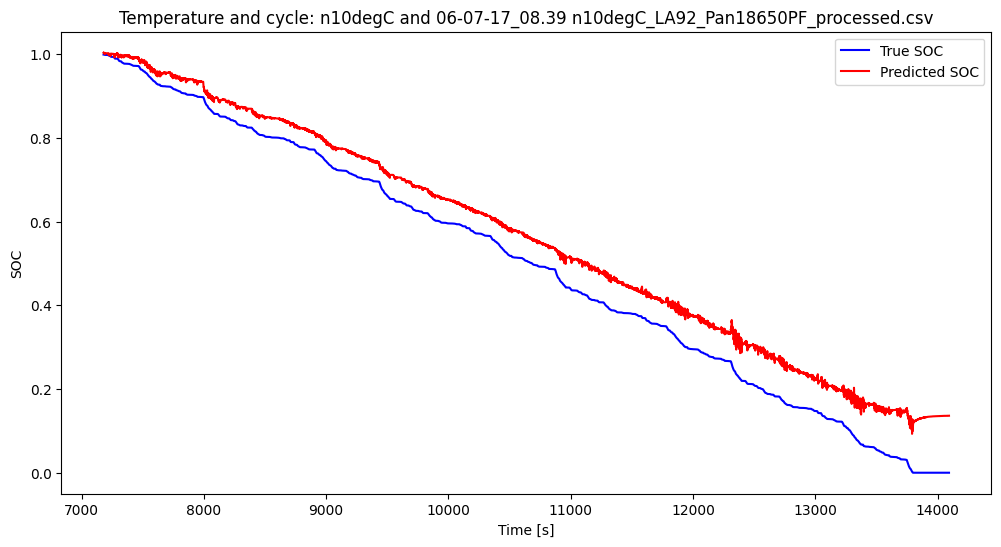


Metrics for n10degC/06-07-17_08.39 n10degC_LA92_Pan18650PF_processed.csv:
Test MSE: 0.004771
Test MAE: 0.063583
Test StdDev: 0.026978


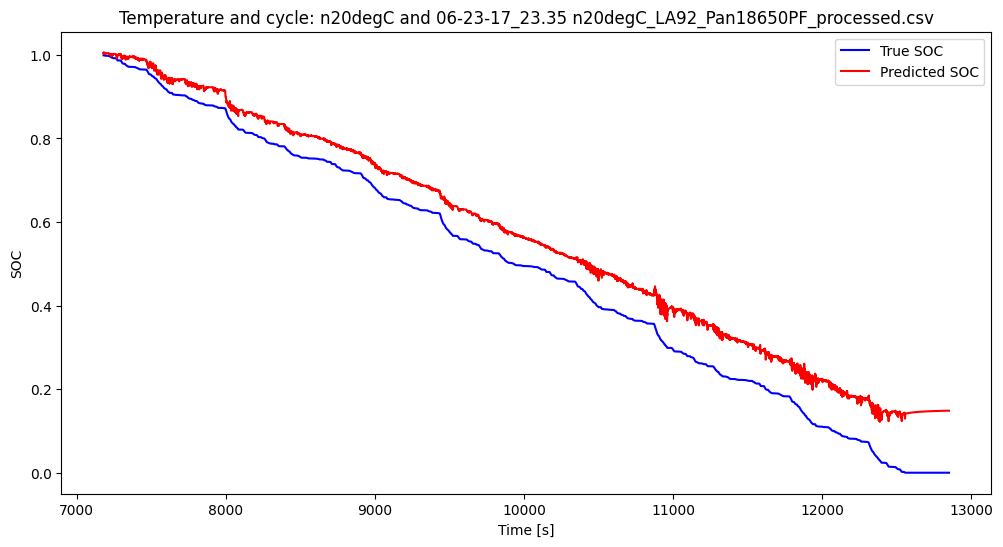


Metrics for n20degC/06-23-17_23.35 n20degC_LA92_Pan18650PF_processed.csv:
Test MSE: 0.006199
Test MAE: 0.072183
Test StdDev: 0.031443


In [152]:
metrics_results = evaluate_and_plot(model, collect_data_panasonic('LA92'))

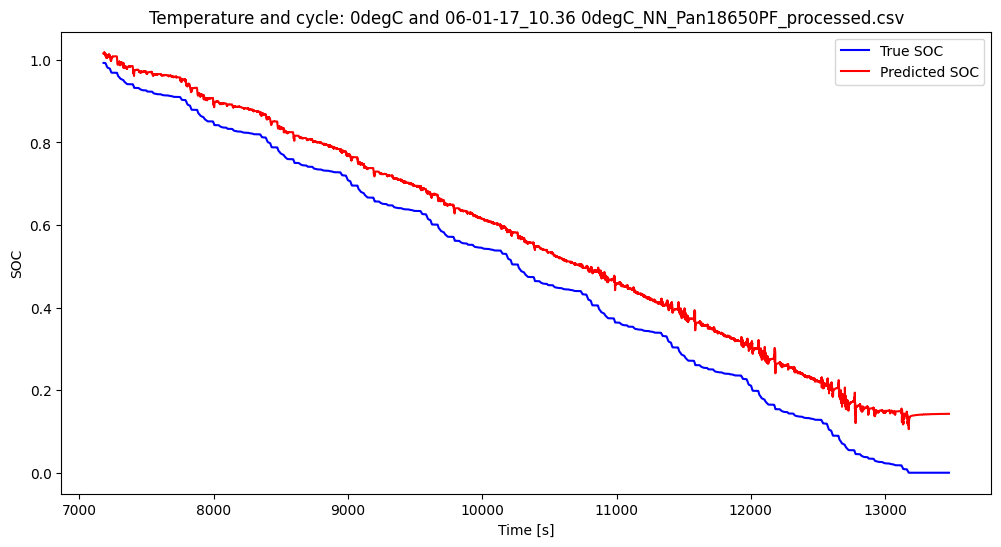


Metrics for 0degC/06-01-17_10.36 0degC_NN_Pan18650PF_processed.csv:
Test MSE: 0.007213
Test MAE: 0.080702
Test StdDev: 0.026456


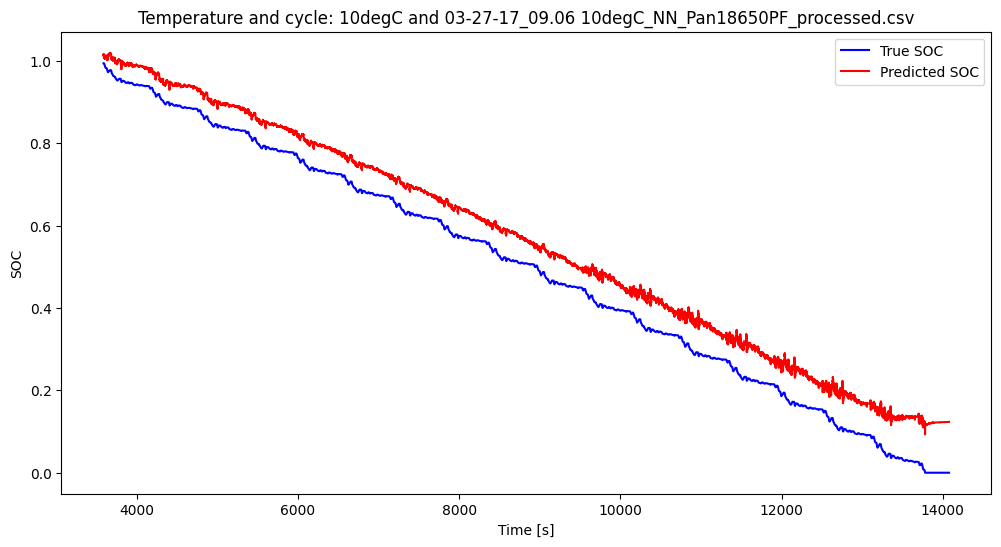


Metrics for 10degC/03-27-17_09.06 10degC_NN_Pan18650PF_processed.csv:
Test MSE: 0.004700
Test MAE: 0.066322
Test StdDev: 0.017362


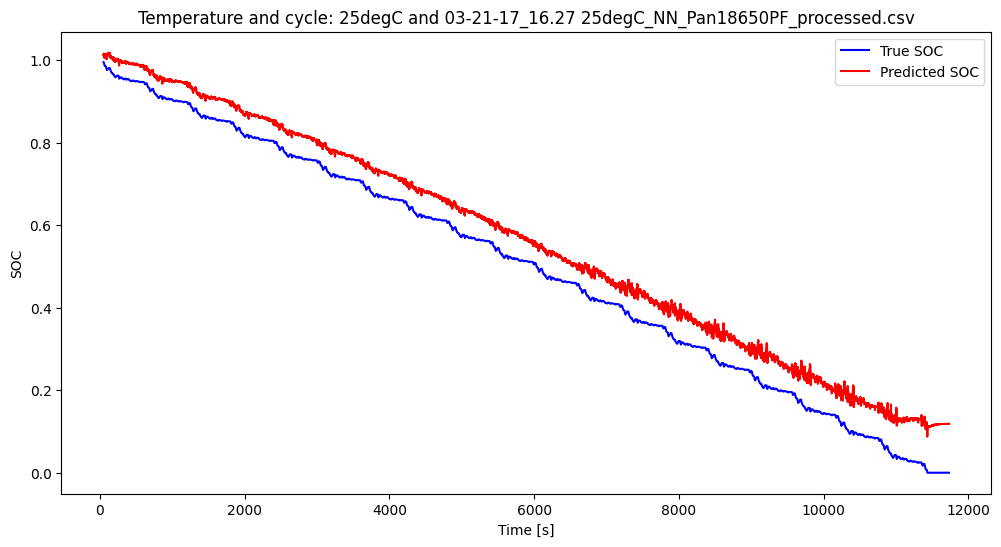


Metrics for 25degC/03-21-17_16.27 25degC_NN_Pan18650PF_processed.csv:
Test MSE: 0.004084
Test MAE: 0.061649
Test StdDev: 0.016820


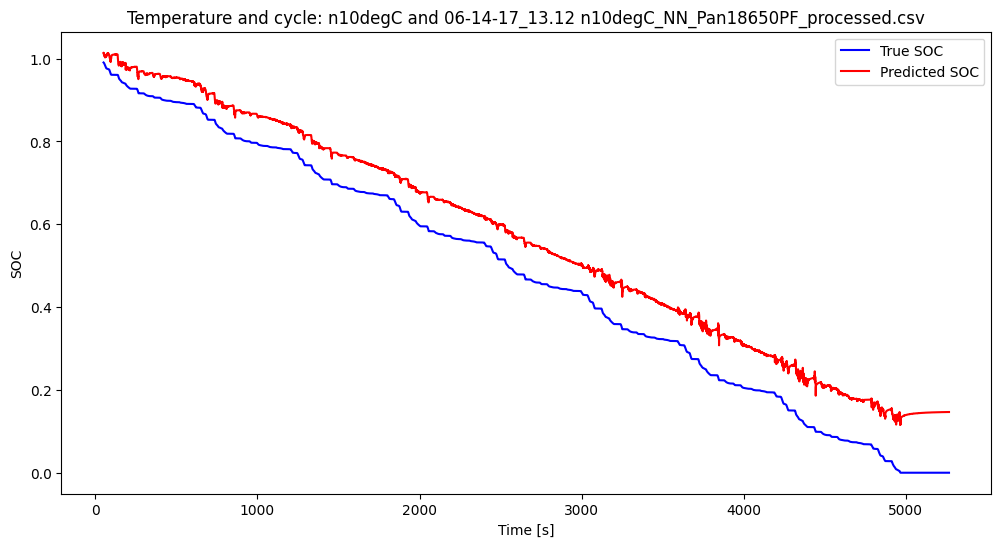


Metrics for n10degC/06-14-17_13.12 n10degC_NN_Pan18650PF_processed.csv:
Test MSE: 0.007785
Test MAE: 0.084763
Test StdDev: 0.024494


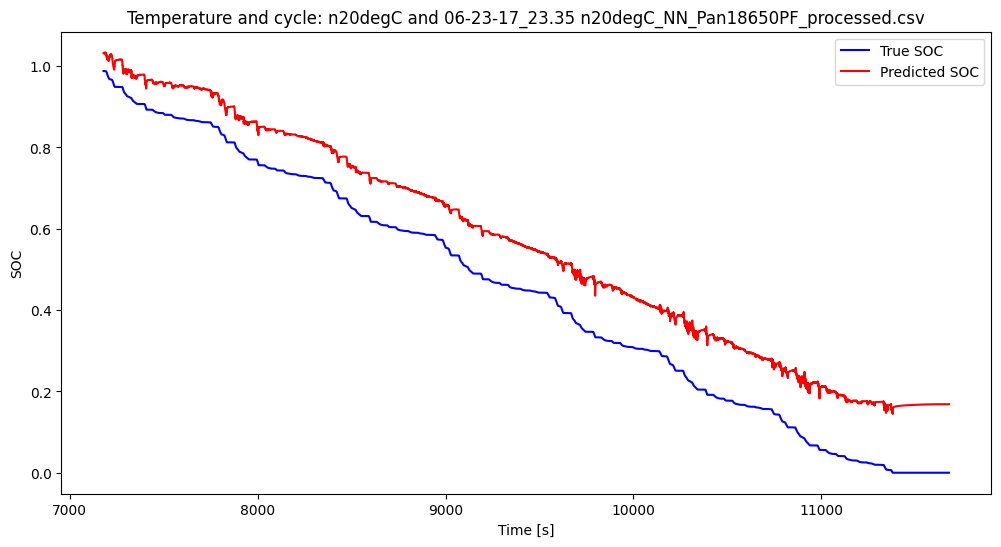


Metrics for n20degC/06-23-17_23.35 n20degC_NN_Pan18650PF_processed.csv:
Test MSE: 0.013939
Test MAE: 0.114574
Test StdDev: 0.028496


In [153]:
metrics_results = evaluate_and_plot(model, collect_data_panasonic('NN'))

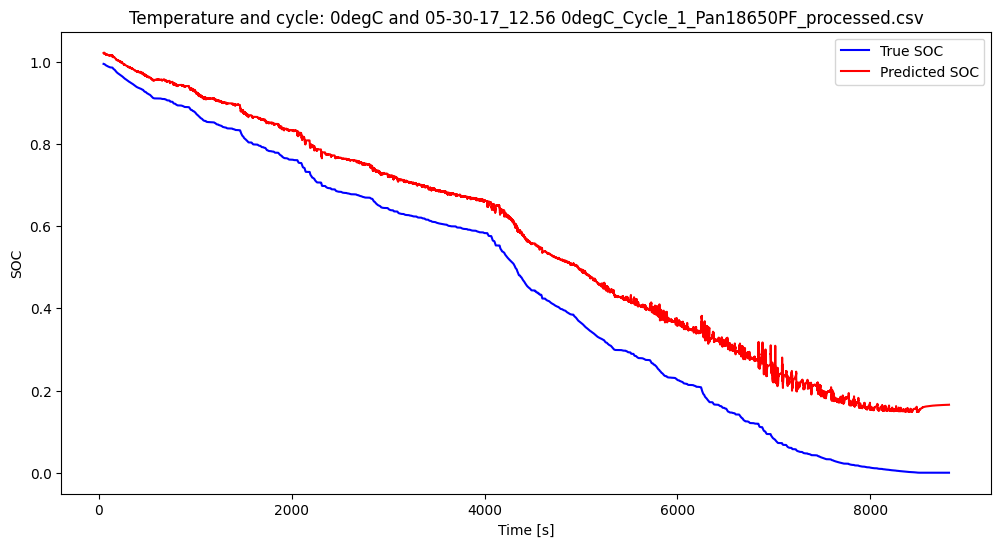


Metrics for 0degC/05-30-17_12.56 0degC_Cycle_1_Pan18650PF_processed.csv:
Test MSE: 0.013309
Test MAE: 0.107323
Test StdDev: 0.042316


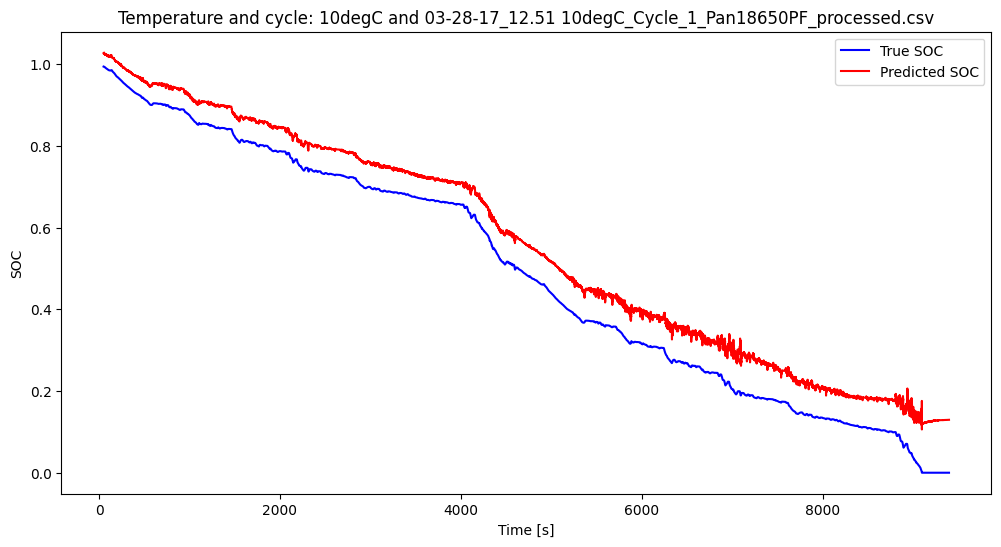


Metrics for 10degC/03-28-17_12.51 10degC_Cycle_1_Pan18650PF_processed.csv:
Test MSE: 0.005156
Test MAE: 0.069453
Test StdDev: 0.018228


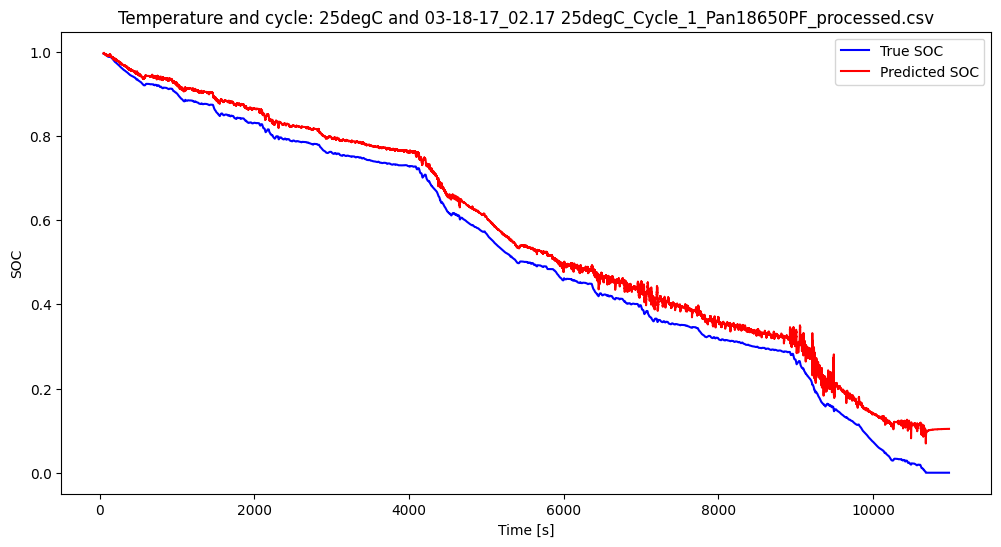


Metrics for 25degC/03-18-17_02.17 25degC_Cycle_1_Pan18650PF_processed.csv:
Test MSE: 0.002087
Test MAE: 0.041494
Test StdDev: 0.019117


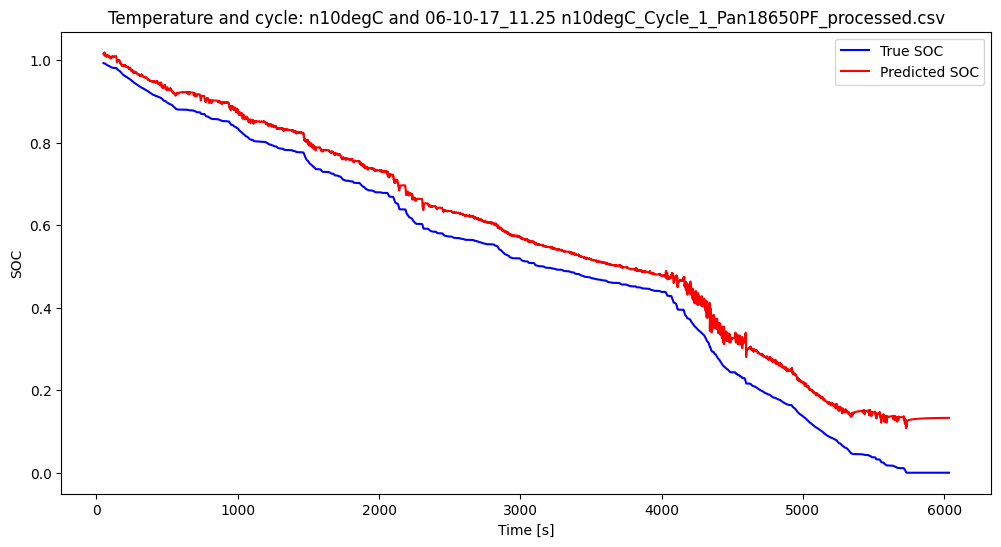


Metrics for n10degC/06-10-17_11.25 n10degC_Cycle_1_Pan18650PF_processed.csv:
Test MSE: 0.004603
Test MAE: 0.062377
Test StdDev: 0.026687


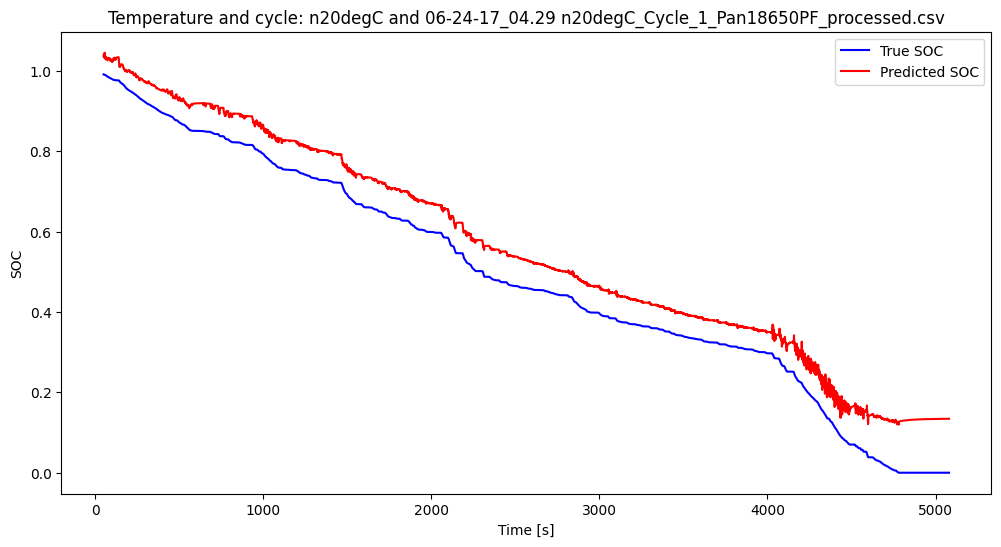


Metrics for n20degC/06-24-17_04.29 n20degC_Cycle_1_Pan18650PF_processed.csv:
Test MSE: 0.005529
Test MAE: 0.071576
Test StdDev: 0.020159


In [154]:
metrics_results = evaluate_and_plot(model, collect_data_panasonic('Cycle_1'))